# <font color=blue> DeepFRC </font>

In [1]:
import pandas as pd
import numpy as np
import os
import sys

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.optim import lr_scheduler
from pathlib import Path
import time

# Plotting Packages
import matplotlib.pyplot as plt
import seaborn as sbn
import matplotlib as mpl

In [2]:
if torch.cuda.is_available():
    print("GPU is available and being used.")
else:
    print("GPU is not available or not being used.")

from google.colab import drive
drive.mount('/content/gdrive/')

GPU is available and being used.
Mounted at /content/gdrive/


In [3]:
%cd /content/gdrive/MyDrive/Colab_Notebooks/DeepFRC-main/DeepFRC

/content/gdrive/MyDrive/Colab_Notebooks/DeepFRC-main/DeepFRC


In [ ]:
# Interp1D
from fun_helpers.torchinterp1d import Interp1d
# Function Helper
from fun_helpers.functions_helper_rn import r_mean_inverse, compute_signal_statistics \
,localization, Generate_centralized_warping_functions, plot_warped_data_analysis, SrvfClasNet

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using {device}...')

# the folder where you save trained model & checkpoints
cur_dir = os.getcwd()
print(f"cur_dir: {cur_dir}")
folder = cur_dir + '/train/'
Path(folder).mkdir(parents=True, exist_ok=True)

Using cuda:0...
cur_dir: /content/gdrive/MyDrive/Colab_Notebooks/DeepFRC-main/DeepFRC


# Prepare Data

In [ ]:
data_dir = "data/"
splitted_train_data = pd.read_csv(data_dir + "train.csv", header=None)
splitted_valid_data = pd.read_csv(data_dir + "valid.csv", header=None)
splitted_test_data = pd.read_csv(data_dir + "test.csv", header=None)
num_train, num_valid, num_test = len(splitted_train_data), len(splitted_valid_data), len(splitted_test_data)
num_train, num_valid, num_test

(1600, 400, 4000)

In [ ]:
splitted_train_data[splitted_train_data.columns[-1]].value_counts()

,count
1000,
0,800
1,800


In [ ]:
splitted_valid_data[splitted_valid_data.columns[-1]].value_counts()

,count
1000,
0,200
1,200


In [ ]:
splitted_test_data[splitted_test_data.columns[-1]].value_counts()

,count
1000,
0,2000
1,2000


In [ ]:
# random shuffle
random_seed = 3407
np.random.seed(random_seed)
_order_train = list(range(num_train))
_order_valid = list(range(num_valid))
_order_test = list(range(num_test))
np.random.shuffle(_order_train)
np.random.shuffle(_order_valid)
np.random.shuffle(_order_test)

splitted_train_data_np = splitted_train_data.values
splitted_valid_data_np = splitted_valid_data.values
splitted_test_data_np = splitted_test_data.values

raw_train_data = splitted_train_data_np[_order_train, :]
raw_valid_data = splitted_valid_data_np[_order_valid, :]
raw_test_data = splitted_test_data_np[_order_test, :]

# the last col is response variable
data_train = raw_train_data[:, :-1]
label_train = raw_train_data[:, [-1]]
data_valid = raw_valid_data[:, :-1]
label_valid = raw_valid_data[:, [-1]]
data_test = raw_test_data[:, :-1]
label_test = raw_test_data[:, [-1]]
print(data_train.shape, label_train.shape)
print(data_valid.shape, label_valid.shape)
print(data_test.shape, label_test.shape)

(1600, 1000) (1600, 1)
(400, 1000) (400, 1)
(4000, 1000) (4000, 1)


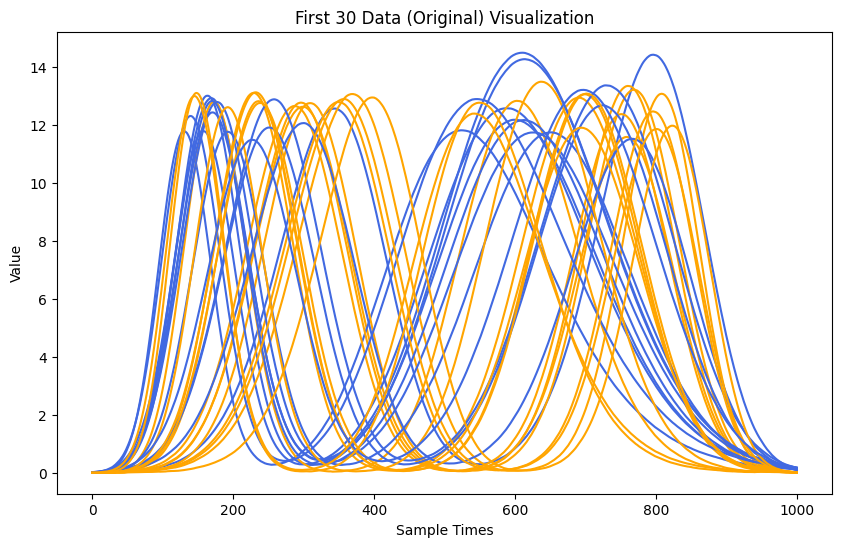

In [ ]:
data = np.concatenate((data_train, data_valid, data_test), axis=0)
label = np.concatenate((label_train, label_valid, label_test))

# Visualize
# plot each class in one color
num_samples = 30
shown_data = data[:num_samples]
seq_len= data.shape[1]
fig, ax = plt.subplots(figsize=(10, 6))
x_values = np.arange(seq_len)
for i in range(num_samples):
    if label[i] == 1:
        plt.plot(shown_data[i], color='royalblue')
    else:
        plt.plot(shown_data[i], color='orange')
ax.set_xlabel('Sample Times')
ax.set_ylabel('Value')
plt.title(f'First {num_samples} Data (Original) Visualization')
# ax.legend()
plt.show()

Data is normalized...
torch.Size([1600, 1, 1001]) torch.Size([400, 1, 1001]) torch.Size([4000, 1, 1001])


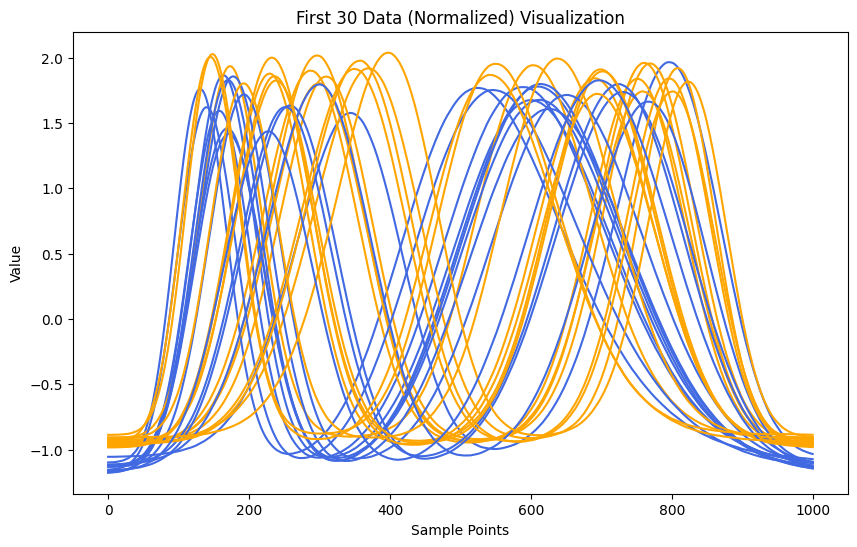

In [ ]:
# Normalize (through row direction)
def Normalization_on_data(input_f):
    '''
    input_f N,C=1,L : () torch.tensor
    Output N,C=1,L: After Z normalization
    '''
    length = input_f.size()[2]
    miu = torch.mean(input_f,dim=2).repeat(1,length).unsqueeze(1)
    input_f = input_f - miu
    sigma = input_f.std(dim=2,keepdim=True)
    input_f = input_f / sigma
    return input_f, miu, sigma

# backup raw data
train_n, valid_n = num_train, num_valid
raw_data_train, raw_data_valid, raw_data_test = data_train, data_valid, data_test
raw_label_train, raw_label_valid, raw_label_test = label_train, label_valid, label_test
# apply normalization
data = torch.from_numpy(data).unsqueeze(1)
norm_data, miu, sigma = Normalization_on_data(data)
# Sanity check
is_one = torch.isclose(norm_data.std(dim=2)[0][0], torch.tensor(1.0, dtype=norm_data.dtype), rtol=1e-05, atol=1e-08)
if not is_one:
    raise("ERROR in normalization, plz check!")
else:
    print("Data is normalized...")

# save miu & sigma
miu_train = miu[:train_n, :, :]
miu_valid = miu[train_n:(train_n+valid_n), :, :]
miu_test = miu[(train_n+valid_n):, :, :]
sigma_train = sigma[:train_n, :, :]
sigma_valid = sigma[train_n:(train_n+valid_n), :, :]
sigma_test = sigma[(train_n+valid_n):, :, :]
# print(f"miu_train: {miu_train.shape}\nmiu_valid: {miu_valid.shape}\nmiu_test: {miu_test.shape}")
# print(f"sigma_train: {sigma_train.shape}\nsigma_valid: {sigma_valid.shape}\nsigma_test: {sigma_test.shape}")

# Visualize normalized data
norm_data_train = norm_data[:train_n, :]
norm_data_valid = norm_data[train_n:(train_n+valid_n), :]
norm_data_test = norm_data[(train_n+valid_n):, :]
label_train = torch.as_tensor(raw_label_train).unsqueeze(1)
label_valid = torch.as_tensor(raw_label_valid).unsqueeze(1)
label_test = torch.as_tensor(raw_label_test).unsqueeze(1)
processed_data_train = torch.cat((norm_data_train, label_train), 2)
processed_data_valid = torch.cat((norm_data_valid, label_valid), 2)
processed_data_test = torch.cat((norm_data_test, label_test), 2)
processed_data_train = processed_data_train.float().to(device)
processed_data_test = processed_data_test.float().to(device)
processed_data_valid = processed_data_valid.float().to(device)
print(processed_data_train.shape, processed_data_valid.shape, processed_data_test.shape)

processed_data = torch.cat((processed_data_train, processed_data_valid, processed_data_test), 0)
processed_label = processed_data.squeeze(1)[:, -1]

shown_data_normed = processed_data[:num_samples].cpu().numpy()
fig, ax = plt.subplots(figsize=(10, 6))
x_values = np.arange(seq_len)
for i in range(num_samples):
    if label[i] == 1:
        plt.plot(shown_data_normed[i, 0, :-1], color='royalblue')
    else:
        plt.plot(shown_data_normed[i, 0, :-1], color='orange')
ax.set_xlabel('Sample Points')
ax.set_ylabel('Value')
plt.title(f'First {num_samples} Data (Normalized) Visualization')
# ax.legend()
plt.show()

In [ ]:
def to_fourier_coefficients(data, n=5):
    '''
    data: N,C,L
    n: the number of fourier coefficients
    '''
    batch_size = data.shape[0]

    fourier_coefficients = torch.fft.rfft(data, dim=1).to(device)
    num_coefficients = n
    truncated_coefficients = fourier_coefficients[:, :num_coefficients].to(device)
    truncated_coefficients.to(device)

    cosine_coefficients = truncated_coefficients.real
    sine_coefficients = -truncated_coefficients.imag

    cosine_coefficients = cosine_coefficients.to(device)
    sine_coefficients = sine_coefficients.to(device)
    return torch.cat([cosine_coefficients, sine_coefficients], dim=1)

# Model

In [ ]:
class LayerNorm(nn.Module):

    def __init__(self, d, eps=1e-6):
        super().__init__()
        # d is the normalization dimension
        self.d = d
        self.eps = eps
        self.alpha = nn.Parameter(torch.randn(d))
        self.beta = nn.Parameter(torch.randn(d))

    def forward(self, x):
        # x is a torch.Tensor
        # avg is the mean value of a layer
        avg = x.mean(dim=-1, keepdim=True)
        # std is the standard deviation of a layer (eps is added to prevent dividing by zero)
        std = x.std(dim=-1, keepdim=True) + self.eps
        return (x - avg) / std * self.alpha + self.beta

# we deal with 2-class as example
num_class = 2
class FeedForward(nn.Module):
    def __init__(self, in_d=1, hidden=[4,8], dropout=0.1, activation=F.relu):
        # in_d      : input dimension, integer
        # hidden    : hidden layer dimension, array of integers
        # dropout   : dropout probability, a float between 0.0 and 1.0
        # activation: activation function at each layer
        super().__init__()
        self.sigma = activation
        dim = [in_d] + hidden + [num_class]
        self.layers = nn.ModuleList([nn.Linear(dim[i-1], dim[i]) for i in range(1, len(dim))])
        self.ln = nn.ModuleList([LayerNorm(k) for k in hidden])
        self.dp = nn.ModuleList([nn.Dropout(dropout) for _ in range(len(hidden))])

    def forward(self, t):
        for i in range(len(self.layers)-1):
            t = self.layers[i](t)
            # skipping connection
            t = t + self.ln[i](t)
            t = self.sigma(t)
            # apply dropout
            t = self.dp[i](t)
        # just return the logits since we will use CrossEntropyLoss which contains nn.LogSoftmax() and nn.NLLLoss()
        return self.layers[-1](t)

def hidden_to_fc_calculation(input_f,localization=localization):
    '''
    input_f : The input data
    localization : Layers to generate hidden features
    '''
    vv = localization(input_f.cpu().float()).detach()
    vv = vv.view(input_f.size(0), -1)
    return vv.size(-1), input_f.size(-1)

hidden_to_fc, fun_len = hidden_to_fc_calculation(processed_data_train[:, :, :-1])

# Set srvf params
Srvf_params = {
    "hidden_to_fc": hidden_to_fc,
    "fun_len": fun_len,
    "Interp1d": Interp1d,
    "device": device
}

# Set ff params
FF_params = {
    "in_d": 100,
    "hidden": [16, 8],
    "dropout": 0.1
}

# RegisNet
class regisNet(nn.Module):
    def __init__(self, Srvf_params, FF_params):
        super().__init__()
        self.srvfNet = SrvfClasNet(**Srvf_params)
        self.classifier = FeedForward(**FF_params)

    def forward(self, input):
        # Warped Q, gamma
        Q, f_r, gamma = self.srvfNet(input)
        seris = to_fourier_coefficients(f_r,50)
        seris = seris
        # the forward pass return "un-centered gamma"
        # the warped sequence (NOT in Srvf space!) are fed into FCN module
        #print(f"shape of seris: {seris.shape}")
        y = self.classifier(seris)
        return y, Q, gamma, f_r

model = regisNet(Srvf_params, FF_params).to(device)

# Training Config

In [ ]:
def save_model(folder, k, Srvf_params, FF_params, model, optimizer):
    checkpoint = {'Srvf_params': Srvf_params,
                  'FF_params': FF_params,
                  'state_dict': model.state_dict(),
                  'optimizer': optimizer.state_dict()}
    torch.save(checkpoint, folder + str(k) + '_' + 'checkpoint.pth')

def load_model(file_path, device):
    checkpoint = torch.load(file_path)
    model = regisNet(Srvf_params=checkpoint['Srvf_params'],
                            FF_params=checkpoint['FF_params'])
    model.load_state_dict(checkpoint['state_dict'])
    _ = model.to(device)
    return model

###########################################################################
alpha_1 = 0.1 # 600
alpha_2 = 1 # 0, 1, 10, 20, 25
num_epochs = 300
batch_size = processed_data_train.size(0) # batch size need to be small or equal to sample size
learning_rate_srvf = 0.001 # 0.0015, 0.0012, 0.001, 3e-3
learning_rate_fcn = 0.001 #0.005 0.0015
params_dict = [{'params': model.srvfNet.parameters()  , 'lr': learning_rate_srvf},
             {'params': model.classifier.parameters(), 'lr': learning_rate_fcn}]
criterion        = nn.CrossEntropyLoss()
optimizer        = torch.optim.AdamW(params_dict)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.9)
save_model_every = 1
seq_len          = fun_len
mse_criterion    = nn.MSELoss(reduction='mean')
###########################################################################
alpha = alpha_1
lamda = alpha_2

In [ ]:
class EarlyStopping_Fire_Down:
    def __init__(self, total_patience=20, loss_min_delta=0.001, acc_min_delta=0.01, regis_patience=15, regis_min_delta=0.00045, classify_min_delta=0.1):
        ###############################
        # control stop
        self.patience = total_patience
        self.counter = 0
        self.stop = False
        # moniter loss change
        self.loss_min_delta = loss_min_delta
        self.best_sub_loss = None
        self.best_loss = None # this track the total loss
        # moniter acc change
        self.acc_min_delta = acc_min_delta
        self.best_acc = None # this track the acc
        ###############################
        # control freeze
        self.regis_patience = regis_patience
        self.regis_min_delta = regis_min_delta
        self.regis_counter = 0
        self.best_regis_loss = None # this track the regis loss (fire down when regis module is improved to bottleneck)
        self.best_ce_loss = None
        self.freeze = False
        self.classify_min_delta = classify_min_delta
        ###############################

    def __call__(self, subLoss_val, val_loss, regis_loss, valid_acc, ce_loss):
        #####################################################################################
        if self.best_sub_loss is None:
            self.best_sub_loss = subLoss_val
        if self.best_loss is None:
            self.best_loss = val_loss
        if self.best_acc is None:
            self.best_acc = valid_acc
        if self.best_ce_loss is None:
            self.best_ce_loss = ce_loss

        valid_sub_loss_delta = self.best_sub_loss - subLoss_val
        valid_loss_delta = self.best_loss - val_loss
        valid_acc_delta = valid_acc - self.best_acc
        valid_ce_loss_delta = self.best_ce_loss - ce_loss
        ###################################### Control Freeze #######################################
        # update ce_loss
        if valid_ce_loss_delta > 0:
            self.best_ce_loss = ce_loss
        # Consider classification (if regis loss gets lower but CE gets higher / (acc drops), we should also stop updates on whole network)
        # instead, we need to focus on classification now
        if self.freeze==False:
            if self.best_regis_loss is None:
                self.best_regis_loss = regis_loss
            elif self.best_regis_loss > regis_loss and self.best_regis_loss - regis_loss <= self.regis_min_delta: # regis_loss gets better
                self.best_regis_loss = regis_loss
                if valid_ce_loss_delta < -self.loss_min_delta * 2:
                    self.regis_counter += 1
            elif self.best_regis_loss - regis_loss > self.regis_min_delta: # regis_loss gets way better
                self.best_regis_loss = regis_loss
                self.regis_counter = 0 # reset freeze_counter
                if valid_ce_loss_delta < -self.loss_min_delta * 2:
                    self.regis_counter += 1
            else: # if regis_loss gets worse
                self.regis_counter += 1
                if self.regis_counter >= self.regis_patience:
                    self.freeze = True
                    # counter
                    self.counter = 0
                    self.loss_min_delta = self.classify_min_delta

        #######################################################################################
        #######################################################################################
        if valid_acc_delta > 0 and valid_loss_delta > 0:
            self.best_acc = valid_acc
            self.best_loss = val_loss
            if valid_acc_delta > self.acc_min_delta and valid_loss_delta > self.loss_min_delta:
                self.counter = 0

        elif valid_acc_delta > 0 and valid_loss_delta <= 0:
            self.best_acc = valid_acc # update acc
            if valid_acc_delta > self.acc_min_delta * 2:
                self.counter -= 1  # back

        elif valid_acc_delta <= 0 and valid_loss_delta > 0:
            self.best_loss = val_loss # update loss
            if valid_loss_delta > self.loss_min_delta * 2:
                self.counter -= 1  # back
            if valid_ce_loss_delta < -self.loss_min_delta * 2:
                self.counter += 1

        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.stop = True  # when total valid loss can't improve, stop training
        ##############################################################################
        # track sub_loss
        if valid_sub_loss_delta > 0:
            self.best_sub_loss = subLoss_val
        #################### if in finetuning classifier (frozen) ####################
        if self.freeze:
            if valid_loss_delta < 0:
                self.counter += 1

early_stopping_firedown = EarlyStopping_Fire_Down(total_patience=120, loss_min_delta=0.5, acc_min_delta=0.01, regis_patience=80, regis_min_delta=0.5, classify_min_delta=0.1)

(Optional) visualize Q before training

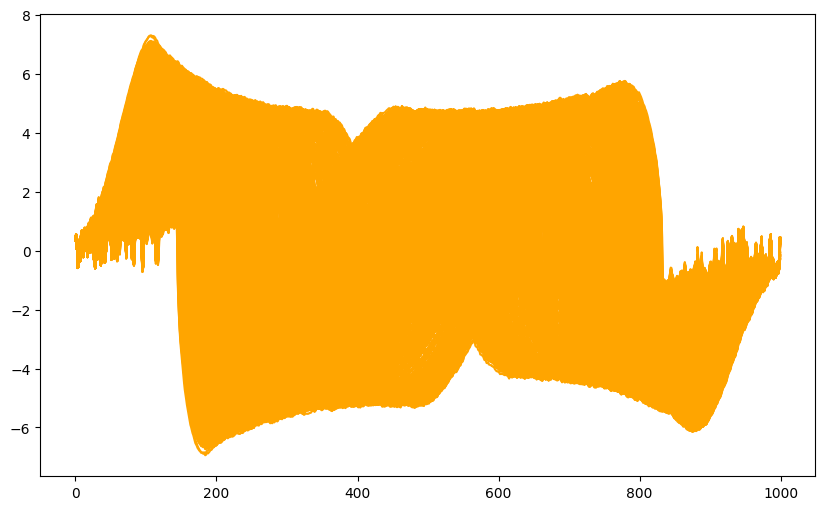

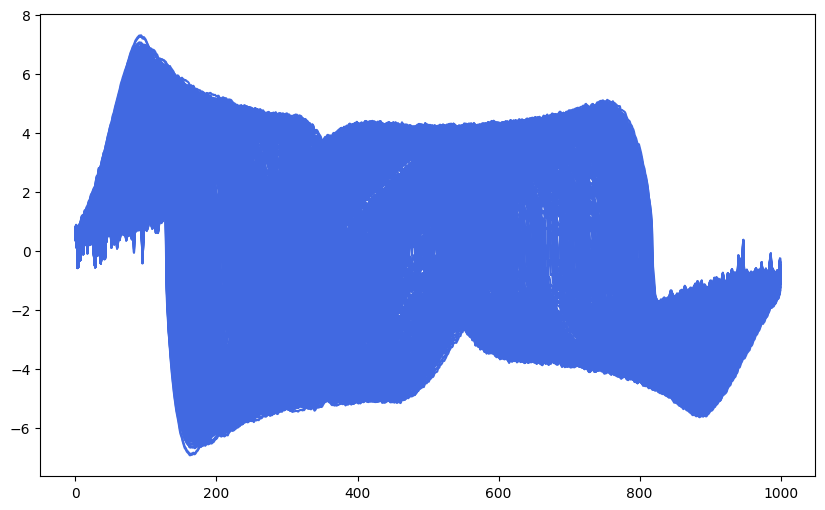

In [ ]:
def gradient(f):
        """
        Central difference method with equal space in dx(i.e.1)
        Input : f in tensor (batch size x fun len)
        Output : gradient along axis fun len(dim=1)

        """
        row_num = f.ndim  # y.size()[0]
        dx = torch.arange(f.size()[1])  # only 1d
        output = torch.empty_like(f)
        # i=0
        output[:, 0] = torch.div(
            f[:, 1] - f[:, 0], dx[1] - dx[0]
        )  # y[:,1] - y[:,0]/ dx[1]-dx[0]
        # i = end
        output[:, -1] = torch.div(
            f[:, -1] - f[:, -2], dx[-1] - dx[-2]
        )  # y[:,-1] - y[:,-2]/  dx[-1]-dx[-2]
        # i = 1:end-1
        for i in range(1, len(dx) - 1):
            output[:, i] = torch.div(f[:, i - 1] - f[:, i + 1], dx[i - 1] - dx[i + 1])
        return output

def srvf(v, gradient):
        """
        v (batch size x fun len )
        q = sign(f')* sqrt(|f'|)
        No backward
        """
        f = v.detach()
        q = torch.empty_like(f)
        batch, length = f.size()
        length_adjust = length - 1
        grad_f = gradient(f * length_adjust)
        for i in range(batch):
            q[i, :] = torch.sign(grad_f[i, :]) * torch.sqrt(grad_f[i, :].abs())
        return q

batch_data = processed_data_train
# r is the gamma function
# Q is the warped data (in srvf space)
bat_data = batch_data[:, :, :-1]
bat_data_shape = bat_data.shape
# bat_label = batch_data[:, :, [-1]]s
bat_label = batch_data[:, :, -1]
bat_label_shape = bat_label.shape
# divide batch_data into two parts now: data_A and data_B based on their label
data_A = bat_data[bat_label == 0]
data_B = bat_data[bat_label == 1]
data_A_shape = data_A.shape
data_B_shape = data_B.shape
data_A = data_A.unsqueeze(1)
data_B = data_B.unsqueeze(1)

length_adjust = seq_len - 1
q_A = srvf(data_A.squeeze(1), gradient)
q_B = srvf(data_B.squeeze(1), gradient)

# plot all the curve in q_A in one color
plt.figure(figsize=(10, 6))
for i in range(q_A.shape[0]):
    plt.plot(q_A.cpu()[i, :], color='orange')

# plot all the curve in q_B in one color
plt.figure(figsize=(10, 6))
for i in range(q_B.shape[0]):
    plt.plot(q_B.cpu()[i, :], color='royalblue')
plt.show()

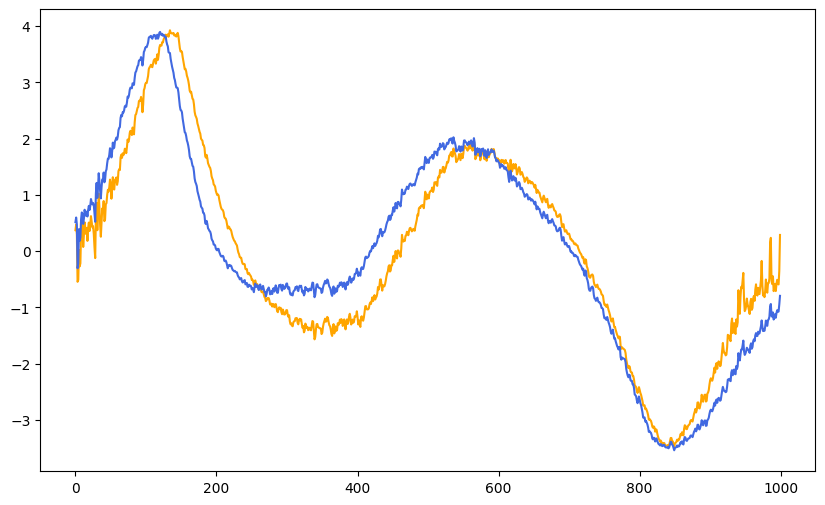

In [ ]:
# plot q_mean_A and q_mean_B in one plot but with different color
q_mean_A = q_A.mean(0, keepdim=True)
q_mean_B = q_B.mean(0, keepdim=True)
plt.figure(figsize=(10, 6))
plt.plot(q_mean_A.cpu().squeeze(0), color='orange')
plt.plot(q_mean_B.cpu().squeeze(0), color='royalblue')
plt.show()

In [ ]:
def train_model_trainval(
    model,
    batch_size,
    num_epochs,
    data_train,
    data_val,
    optimizer,
    criterion,
    device,
    schedular,
    lamda,
    subLoss_val=[],
    loss_val=[],
    loss_train=[],
    left_loss_train=[],
    right_loss_train=[],
    penal_1_train=[],
    acc_val=[],
    regis_loss_valid=[],
    regisA_loss_valid=[],
    regisB_loss_valid=[],
    regisA_loss_train=[],
    regisB_loss_train=[],
    classify_loss_valid=[],
    Q_A_train_history=[],
    Q_B_train_history=[],
    Q_A_mean_train_history=[],
    Q_B_mean_train_history=[],
    Q_A_valid_history=[],
    Q_B_valid_history=[],
    Q_A_mean_valid_history=[],
    Q_B_mean_valid_history=[],
    visualize_Q_for_n_times=10,
    time=time,
):
    """
    model : The model uses
    batch_size : For both training and validation
    criterion : CrossEntropyLoss
    device : cpu or cuda
    schedular : learing rate decay
    loss_val : The record of validation loss
    loss_train : The record of training loss
    """
    opt = optimizer
    best_model = None
    best_val = 10000
    best_train = -1
    best_epoch = 1
    since = time.time()
    magic_token = True
    control_penalty_mse = alpha # 20
    mac = 1

    # In case batch size > test data size
    if batch_size > data_val.size()[0]:
        val_batch_size = data_val.size()[0]
    else:
        val_batch_size = batch_size

    # model.to(device)
    num_iteration_epoch_train = int(data_train.size()[0] / batch_size)
    num_iteration_epoch_val = int(data_val.size()[0] / val_batch_size)

    # Save best model
    # best_model = copy.deepcopy(model.state_dict())

    visual_Q_every = num_epochs // visualize_Q_for_n_times

    for epoch in range(num_epochs):
        visualize_Q = False
        if epoch and epoch % save_model_every == 0:
            save_model(
                folder=folder,
                k=epoch,
                Srvf_params=Srvf_params,
                FF_params=FF_params,
                model=model,
                optimizer=opt,
            )
        if epoch and epoch % visual_Q_every == 0:
            visualize_Q = True

        # Each epoch has a training and validation phase
        for phase in ["val", "train"]:
            # val first, train later
            # "Validation"
            if phase == "val":
                with torch.no_grad():
                    model.eval()  # Set model to validation mode
                    loss_epoch_val = 0.0
                    regis_loss_epoch_val = 0.0
                    regisA_loss_epoch_val = 0.0
                    regisB_loss_epoch_val = 0.0
                    classify_loss_epoch_val = 0.0
                    subLoss_epoch_val = 0.0
                    acc_epoch_val = 0.0
                    valdata_shuffle = data_val
                    # we don't need to shuffle the valid set
                    # [torch.randperm(data_val.size()[0]),:,:]
                    # size: (val_batch_size, 1, 99+1)

                    for iteration in range(num_iteration_epoch_val):
                        batch_data = valdata_shuffle[
                            val_batch_size
                            * (iteration) : val_batch_size
                            * (iteration + 1),
                            :,
                            :,
                        ].to(device)

                        batch_data_shape = batch_data.shape
                        # print(f"batch_data_shape: {batch_data_shape}")
                        # (64, 1, 100)

                        # r is the gamma function
                        # Q is the warped data (in srvf space)

                        # batch_data: (batch_size, fun_len+1)
                        # We need to divide them into data and label
                        bat_data = batch_data[:, :, :-1]

                        # bat_label = batch_data[:, :, [-1]]
                        bat_label = batch_data[:, :, -1]
                        bat_label_shape = bat_label.shape
                        # size: (val_batch_size, 1)

                        # divide batch_data into two parts now: data_A and data_B based on their label
                        data_A = bat_data[bat_label == 0]
                        data_B = bat_data[bat_label == 1]
                        # remember to keep the dim
                        data_A = data_A.unsqueeze(1)
                        data_B = data_B.unsqueeze(1)

                        # print(f"data_A_shape: {data_A_shape}")
                        # print(f"data_B_shape: {data_B_shape}")
                        # print(f"bat_data_shape: {bat_data.shape}")
                        #################################################################################
                        # for for all the data we divide them by label
                        #### the first part: label = 0
                        y_bar_A, Q_A, r_A, f_r_A = model(data_A)
                        #### the second part: label = 1
                        y_bar_B, Q_B, r_b, f_r_B = model(data_B)

                        #################################################################################
                        # Q_mean_A_single = Q_A.mean(0).detach()
                        # Q_mean_B_single = Q_B.mean(0).detach()
                        Q_mean_A_single = Q_A.mean(0)
                        Q_mean_B_single = Q_B.mean(0)
                        if visualize_Q:
                            Q_A_mean_valid_history.append(Q_mean_A_single)
                            Q_B_mean_valid_history.append(Q_mean_B_single)
                            Q_A_valid_history.append(Q_A)
                            Q_B_valid_history.append(Q_B)

                        ############# Compute Loss #############
                        # Q_mean's size is (val_batch_size, fun_len=99)

                        # now when we compute loss, there are two parts
                        # get the Q_mean of data_A and data_B
                        Q_mean_A = Q_mean_A_single.repeat(data_A.shape[0], 1)
                        Q_mean_B = Q_mean_B_single.repeat(data_B.shape[0], 1)
                        left_loss_A = mse_criterion(Q_A, Q_mean_A)
                        left_loss_B = mse_criterion(Q_B, Q_mean_B)
                        left_loss = left_loss_A + left_loss_B

                        # here is loss for one single batch
                        y_A = bat_label[bat_label == 0]
                        y_B = bat_label[bat_label == 1]

                        """
                        print(f"y_A_shape: {y_A.shape}")
                        print(f"y_B_shape: {y_B.shape}")
                        print(f"y_bar_A_shape: {y_bar_A.shape}")
                        print(f"y_bar_B_shape: {y_bar_B.shape}")
                        """
                        # check dtype
                        # target should be long while prediction should be float (for crossentropy)
                        y_A = y_A.long()
                        y_B = y_B.long()
                        """
                        print(f"y_A dtype: {y_A.dtype}")
                        print(f"y_B dtype: {y_B.dtype}")
                        print(f"y_bar_A dtype: {y_bar_A.dtype}")
                        print(f"y_bar_B dtype: {y_bar_B.dtype}")
                        """
                        # crossentropy
                        right_loss_A = criterion(y_bar_A, y_A)
                        right_loss_B = criterion(y_bar_B, y_B)
                        right_loss = right_loss_A + right_loss_B
                        # loss_epoch_val += left_loss.item() + lamda * right_loss.item()
                        ####### [regis loss]    [classification loss]
                        loss = mac * left_loss + lamda * right_loss
                        ########################################
                        # We add some penalty term to the loss
                        # we want Q_mean_A and Q_mean_B to be different (i.e. the worst case is they are identical)
                        # so we need a penalty term to represent the difference between Q_mean_A and Q_mean_B
                        # we use MSE here
                        diff_dist = mse_criterion(Q_mean_A_single, Q_mean_B_single)
                        # when diff_dist is smaller, the penalty should be larger
                        # so we use 1 / diff_dist
                        penalty = 1 / diff_dist
                        # add penalty to the loss
                        ##############################################
                        # control_p = 15
                        ##############################################
                        penalty_1 = penalty * control_penalty_mse

                        """
                        # Compute cross-correlation
                        # cross_corr = correlate(Q_mean_B, Q_mean_A, mode='full')
                        cross_corr = correlate(Q_mean_B_single.cpu(), Q_mean_A_single.cpu(), mode='full')
                        similarity = cross_corr.max()
                        # control_s = 0.001
                        penalty_2 = similarity * control_penalty_cor
                        """
                        # penalty_total = penalty_1 + penalty_2
                        penalty_total = penalty_1
                        loss += penalty_total
                        ########################################
                        sub_loss = left_loss + penalty_total # omit classification (might be useful before freezing)
                        subLoss_epoch_val += sub_loss.item()
                        ########################################

                        loss_epoch_val += loss.item()
                        regis_loss_epoch_val += left_loss.item()
                        # print(f"regis_loss_epoch_val: {regis_loss_epoch_val}")
                        regisA_loss_epoch_val += left_loss_A.item()
                        regisB_loss_epoch_val += left_loss_B.item()
                        classify_loss_epoch_val += right_loss.item()

                        # calculate accuracy
                        y_bar_A = y_bar_A.squeeze(1)
                        y_bar_B = y_bar_B.squeeze(1)
                        # the index of the largest number in the output logits will be our prediction
                        _, pred_A = torch.max(y_bar_A, 1)
                        _, pred_B = torch.max(y_bar_B, 1)
                        """
                        print(f"pred_A: {pred_A}")
                        print(f"pred_B: {pred_B}")
                        print(f"y_bar_A: {y_bar_A}")
                        print(f"y_bar_B: {y_bar_B}")
                        print(f"y_actual_A: {y_A}")
                        print(f"y_actual_B: {y_B}")
                        """

                        corrected_A = (pred_A == 0).sum().item()
                        corrected_B = (pred_B == 1).sum().item()

                        total_num = bat_data.size(0)
                        # get accuracy
                        acc = (corrected_A + corrected_B) / total_num
                        acc_epoch_val += acc

                    # reocrd epoch per loss
                    subLoss_val.append(subLoss_epoch_val / (iteration + 1))
                    loss_val.append(loss_epoch_val / (iteration + 1))
                    regis_loss_valid.append(regis_loss_epoch_val / (iteration + 1))
                    regisA_loss_valid.append(regisA_loss_epoch_val / (iteration + 1))
                    regisB_loss_valid.append(regisB_loss_epoch_val / (iteration + 1))
                    classify_loss_valid.append(classify_loss_epoch_val / (iteration + 1))
                    acc_val.append(acc_epoch_val / (iteration + 1))
            # "Train"
            else:
                # add learning rate decay
                # if schedular != None:
                model.train()  # Set model to train mode
                loss_epoch_train = 0.0
                ##############################
                # Trace each loss's variation trend
                left_loss_epoch_train = 0.0
                regisA_loss_epoch_train = 0.0
                regisB_loss_epoch_train = 0.0
                right_loss_epoch_train = 0.0
                ##############################
                penal_1_epoch_train = 0.0
                penal_2_epoch_train = 0.0
                ##############################
                # shuffle the training set
                # Here I mute shuffle because I do shuffling on train set before I call this train function
                trainingdata_shuffle = data_train
                # trainingdata_shuffle = data_train[torch.randperm(data_train.size()[0]), :, :]

                for iteration in range(num_iteration_epoch_train):
                    batch_data = trainingdata_shuffle[
                        batch_size * (iteration) : batch_size * (iteration + 1), :, :
                    ].to(device)
                    ###########################

                    bat_data = batch_data[:, :, :-1]
                    bat_data_shape = bat_data.shape
                    # (64, 1, 99)

                    # bat_label = batch_data[:, :, [-1]]
                    bat_label = batch_data[:, :, -1]
                    bat_label_shape = bat_label.shape
                    # size: (val_batch_size, 1)
                    # (64, 1)

                    # divide batch_data into two parts now: data_A and data_B based on their label
                    data_A = bat_data[bat_label == 0]
                    data_B = bat_data[bat_label == 1]
                    # remember to keep the dim
                    data_A = data_A.unsqueeze(1)
                    data_B = data_B.unsqueeze(1)

                    ###########################

                    opt.zero_grad()

                    ##### the first part: label = 0
                    #print(data_A.shape)
                    y_bar_A, Q_A, r_A, f_r_A = model(data_A)    # Q_A & Q_B is the srvf form of warped f, so they're related to parameters' updating
                    #### the second part: label = 1
                    # print(data_B.shape)
                    y_bar_B, Q_B, r_b, f_r_B = model(data_B)

                    # now when we compute loss, there are two parts
                    # get the Q_mean of data_A and data_B (dynamic target)
                    ############################################################################
                    ############################################################################
                    ############################################################################
                    # therefore, Q_A_mean and Q_B_mean also change along epoch changes
                    # and the penalty term ensures the two targets are different
                    # Q_mean_A_single = Q_A.mean(0).detach()
                    Q_mean_A_single = Q_A.mean(0)
                    Q_mean_A = Q_mean_A_single.repeat(data_A.shape[0], 1)

                    # Q_mean_B_single = Q_B.mean(0).detach()
                    Q_mean_B_single = Q_B.mean(0)
                    Q_mean_B = Q_mean_B_single.repeat(data_B.shape[0], 1)

                    if visualize_Q:
                        Q_A_mean_train_history.append(Q_mean_A_single)
                        Q_B_mean_train_history.append(Q_mean_B_single)
                        Q_A_train_history.append(Q_A)
                        Q_B_train_history.append(Q_B)

                    ############################################################################
                    ############################################################################
                    ############################################################################
                    """
                    if epoch == 0:
                        Q_A_start = Q_A_start.repeat(data_A.shape[0], 1)
                        Q_B_start = Q_B_start.repeat(data_B.shape[0], 1)
                        # print(f"Q_A_start's shape: {Q_A_start.shape}")
                        # print(f"Q_B_start's shape: {Q_B_start.shape}")
                    if epoch<10:  #80
                        left_loss_A = mse_criterion(Q_A, Q_A_start)
                        left_loss_B = mse_criterion(Q_B, Q_B_start)
                    else:
                        left_loss_A = mse_criterion(Q_A, Q_mean_A)
                        left_loss_B = mse_criterion(Q_B, Q_mean_B)
                    """
                    left_loss_A = mse_criterion(Q_A, Q_mean_A)
                    left_loss_B = mse_criterion(Q_B, Q_mean_B)
                    ############################################################################
                    regisA_loss_epoch_train += left_loss_A.item()
                    regisB_loss_epoch_train += left_loss_B.item()

                    left_loss = left_loss_A + left_loss_B

                    # here is loss for one single batch
                    y_A = bat_label[bat_label == 0]
                    y_B = bat_label[bat_label == 1]
                    # check dtype
                    # target should be long while prediction should be float (for crossentropy)
                    y_A = y_A.long()
                    y_B = y_B.long()

                    # crossentropy
                    right_loss_A = criterion(y_bar_A, y_A)
                    right_loss_B = criterion(y_bar_B, y_B)
                    right_loss = right_loss_A + right_loss_B

                    loss = mac * left_loss + lamda * right_loss

                    ########################################################################################################################
                    ########################################################################################################################
                    ########################################################################################################################
                    # Now we add some penalty term to the loss
                    # we want Q_mean_A and Q_mean_B to be different (i.e. the worst case is they are identical)
                    # so we need a penalty term to represent the difference between Q_mean_A and Q_mean_B
                    # we use MSE here
                    diff_dist = mse_criterion(Q_mean_A_single, Q_mean_B_single)
                    # when diff_dist is smaller, the penalty should be larger
                    # so we use 1 / diff_dist
                    penalty = 0.1 / diff_dist
                    # add penalty to the loss
                    ##############################################
                    # control_p = 15
                    ##############################################
                    penalty_1 = penalty * control_penalty_mse

                    """
                    # Compute cross-correlation
                    # cross_corr = correlate(Q_mean_B, Q_mean_A, mode='full')
                    cross_corr = correlate(Q_mean_B_single.cpu(), Q_mean_A_single.cpu(), mode='full')
                    similarity = cross_corr.max()
                    # control_s = 0.001
                    # control_s = 0.001
                    penalty_2 = similarity * control_penalty_cor
                    """
                    # penalty_total = penalty_1 + penalty_2
                    penalty_total = penalty_1
                    loss += penalty_total
                    #######################
                    loss_epoch_train += loss.item()
                    #######################
                    left_loss_epoch_train += left_loss.item()
                    right_loss_epoch_train += right_loss.item()
                    #######################
                    penal_1_epoch_train += penalty_1.item()
                    #######################

                    # loss_epoch_train += loss.item()
                    loss.backward()
                    opt.step()

                    # leaning rate decay
                    if schedular != None:
                        schedular.step()

                # reocrd epoch per loss
                n_itr = iteration + 1
                # print(f'n_itr={n_itr}')
                loss_train.append(loss_epoch_train / n_itr)
                left_loss_train.append(left_loss_epoch_train / n_itr)
                regisA_loss_train.append(regisA_loss_epoch_train / (iteration + 1))
                regisB_loss_train.append(regisB_loss_epoch_train / (iteration + 1))
                right_loss_train.append(right_loss_epoch_train / n_itr)

                penal_1_train.append(penal_1_epoch_train / n_itr)

        ########################################
        # Early Stopping (monitor both total valid loss and regis loss to control train schedule)
        early_stopping_firedown(subLoss_val[-1], loss_val[-1], regis_loss_valid[-1], acc_val[-1], classify_loss_valid[-1])

        if early_stopping_firedown.stop:
            print(" === Early stopping triggered === ")
            break
        ########################################
        ########################################
        # FREEZE
        if early_stopping_firedown.freeze and magic_token:
            print("Freezing updates for regis module ~~--z_ _ _ _")
            magic_token = False
            # one time magic
            ###############################################################################################################
            # first of all, save the current model "right_before_freeze.pth" for check effectiveness
            save_model(folder, "right_before_freeze", Srvf_params, FF_params, model, opt)
            ###############################################################################################################
            # retrive the current best model
            # load

            # ck_based_on_xxx = folder + "best_checkpoint.pth"
            ck_based_on_xxx = folder + "best_subLoss_checkpoint.pth"

            # ck_based_on_xxx = folder + "best_checkpoint.pth"
            # since it's still half of training, we focus on loss here
            model = load_model(ck_based_on_xxx, device)
            # train this model from now on

            for param in model.srvfNet.parameters():
                param.requires_grad = False
                # stop updating regis module
                # Reinitialize optimizer - now excluding the frozen parameters
            fine_tune_optimizer = torch.optim.AdamW(
                filter(lambda p: p.requires_grad, model.parameters()),
                # lr = learning_rate_fcn / 10  # 20, 6
                lr = learning_rate_fcn * 0.1
                # lr = learning_rate_fcn * 0.8
            )

            opt = fine_tune_optimizer
            schedular = lr_scheduler.StepLR(opt, step_size=20, gamma=0.9)

            # also, we don't consider the penalty when train since two Q are already frozen

            ## control_penalty_mse = 0

            # do we need to also set lambda to 1 and mute regis loss?
            # to-be-done

            ## mac = 0

            # lamda = 1
            early_stopping_firedown.counter = 0

        ########################################
        ########################################
        best_val = early_stopping_firedown.best_loss
        best_subLoss_val = early_stopping_firedown.best_sub_loss
        ##################################################################################################
        # wait, best model should be decided on acc or val_loss?
        ##################################################################################################
        # additional: best_regis_and_penal
        # (omit classification)
        if best_subLoss_val == subLoss_val[-1]:
            # best_val = loss_val[-1]
            best_model = model
            best_train = loss_train[-1]
            best_epoch = epoch
            # Save the current best model
            save_model(folder, "best_subLoss", Srvf_params, FF_params, model, opt)

        # based on best valid loss
        if best_val == loss_val[-1]:
            # best_val = loss_val[-1]
            best_model = model
            best_train = loss_train[-1]
            best_epoch = epoch
            # Save the current best model
            save_model(folder, "best", Srvf_params, FF_params, model, opt)
        ####################################################################################################
        # based on best valid acc
        best_val_acc = early_stopping_firedown.best_acc

        if best_val_acc == acc_val[-1]:
            # best_val = loss_val[-1]
            best_model_bacc = model
            best_train_bacc = loss_train[-1]
            best_epoch_bacc = epoch
            # Save the current best model
            save_model(folder, "best_acc_", Srvf_params, FF_params, model, opt)

        ####################################################################################################

        print("Epoch : {}".format(epoch))
        print("\t Training loss : {:.5f}".format(loss_train[-1]))
        print("\t Validation loss : {:.5f}".format(loss_val[-1]))
        print("\t (train) Registration loss : {:.5f} \t Classification loss : {:.5f}".format(left_loss_train[-1], right_loss_train[-1]))
        print("\t (valid) Registration loss : {:.5f} \t Classification loss : {:.5f}".format(regis_loss_valid[-1], classify_loss_valid[-1]))
        if not magic_token: # freezed
            print("\t penalty (mse) : [[{:.5f}]]".format(penal_1_train[-1]))
        else:
            print("\t penalty (mse) : {:.5f}".format(penal_1_train[-1]))
        print("\t valid accuracy : {:.5f}".format(acc_val[-1]))
        # print("\t best_subLoss_val：{:.5f}".format(best_subLoss_val))
        # :.4f
        # :.6E, scientific notation
    time_elapsed = time.time() - since
    print(
        "Training complete in {:.4f}s ≈ {:.0f}m {:.0f}s".format(
            time_elapsed, time_elapsed // 60, time_elapsed % 60
        )
    )
    # deep copy the model
    # if phase == 'val' and loss_val[-1] > loss_train[-1]:
    #        best_acc = epoch_acc
    #        best_model_wts = copy.deepcopy(model.state_dict())

    return (
        best_model,
        subLoss_val,
        loss_val,
        loss_train,
        left_loss_train,
        right_loss_train,
        penal_1_train,
        acc_val,
        time_elapsed,
        best_val,
        best_train,
        best_epoch,
        regis_loss_valid,
        regisA_loss_valid,
        regisB_loss_valid,
        regisA_loss_train,
        regisB_loss_train,
        classify_loss_valid,
        Q_A_train_history,
        Q_B_train_history,
        Q_A_mean_train_history,
        Q_B_mean_train_history,
        Q_A_valid_history,
        Q_B_valid_history,
        Q_A_mean_valid_history,
        Q_B_mean_valid_history
    )

# Start training

In [ ]:
model, subLoss_val, loss_val, loss_train, left_loss_train, right_loss_train, penal_1_train, acc_val, time_elapsed, best_val,best_train,best_epoch, regis_loss_valid, regisA_loss_valid, regisB_loss_valid, regisA_loss_train, regisB_loss_train, classify_loss_valid, Q_A_train_history, Q_B_train_history, Q_A_mean_train_history, Q_B_mean_train_history, Q_A_valid_history, Q_B_valid_history, Q_A_mean_valid_history, Q_B_mean_valid_history= train_model_trainval(model=model,batch_size=batch_size, num_epochs=num_epochs,data_train=processed_data_train, device=device,schedular = exp_lr_scheduler ,data_val=processed_data_valid.float() ,optimizer=optimizer, criterion=criterion, lamda=lamda, subLoss_val=[], loss_val=[],loss_train=[],left_loss_train=[],right_loss_train=[],penal_1_train=[], acc_val=[],regis_loss_valid=[], regisA_loss_valid=[], regisB_loss_valid=[], regisA_loss_train=[], regisB_loss_train=[], classify_loss_valid=[], Q_A_train_history=[], Q_B_train_history=[], Q_A_mean_train_history=[], Q_B_mean_train_history=[], Q_A_valid_history=[], Q_B_valid_history=[], Q_A_mean_valid_history=[], Q_B_mean_valid_history=[], visualize_Q_for_n_times=5, time=time)

In [ ]:
# len(regisA_loss_valid), len(regisB_loss_valid), len(regisA_loss_train), len(regisB_loss_train)
plt.figure(figsize=[8.0, 4.8])
plt.plot(regisA_loss_valid,label='regis_loss_A (valid)')
plt.plot(regisA_loss_train,label='regis_loss_A (train)')
plt.xlabel('Epochs')
plt.title('Loss')
plt.legend()

plt.figure(figsize=[8.0, 4.8])
plt.plot(regisB_loss_valid,label='regis_loss_B (valid)')
plt.plot(regisB_loss_train,label='regis_loss_B (train)')
plt.xlabel('Epochs')
plt.title('Loss')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=[8.0, 4.8])
plt.plot(regis_loss_valid,label='regis_loss_valid')
plt.xlabel('Epochs')
plt.title('Loss')
plt.legend()

plt.figure(figsize=[8.0, 4.8])
plt.plot(classify_loss_valid,label='classify_loss_valid')
plt.xlabel('Epochs')
plt.title('Loss')
plt.legend()

plt.figure(figsize=[8.0, 4.8])
plt.plot(penal_1_train,label='penal_1 (mse)')
plt.xlabel('Epochs')
plt.title('Loss')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=[8.0, 4.8])
plt.plot(loss_train,label='Training loss')
plt.plot(left_loss_train,label='Registration loss')
plt.plot(right_loss_train,label='Classification loss')
plt.xlabel('Epochs')
plt.title('Loss')
plt.legend()
plt.show()

*How **Q** change during training

In [ ]:
def plot_tensor_array(tensor_array, seq_len, plot_color, title):
  num_tensors = len(tensor_array)

  for i in range(num_tensors):
    if i==0: # start point
      plt.plot(tensor_array[i].detach().cpu(), color="red", label='start')
    elif i == num_tensors-1:
      plt.plot(tensor_array[i].detach().cpu(), color="green", label='end')
    else:
      plt.plot(tensor_array[i].detach().cpu(), color=plot_color)


  plt.xlabel("X")
  plt.ylabel("Y")
  plt.legend(loc="upper left")
  plt.title(title)
  plt.grid(True)  # Add grid for better readability
  plt.tight_layout()
  plt.show()

plot_tensor_array(Q_A_mean_train_history, seq_len, "orange", "Q_A_train_history")
plot_tensor_array(Q_B_mean_train_history, seq_len, "royalblue", "Q_B_train_history")

In [ ]:
# plot two classes together
def How_Q_change_start_to_end(tensor_array_A, plot_color_A, tensor_array_B, plot_color_B, title):
  # class_A
  plt.plot(tensor_array_A[0].detach().cpu(), color=plot_color_A, linestyle='--') # start
  plt.plot(tensor_array_A[-1].detach().cpu(), color=plot_color_A) # end

  # class_B
  plt.plot(tensor_array_B[0].detach().cpu(), color=plot_color_B, linestyle='--') # start
  plt.plot(tensor_array_B[-1].detach().cpu(), color=plot_color_B) # end

  plt.xlabel("X")
  plt.ylabel("Y")
  plt.title(title)
  plt.grid(True)  # Add grid for better readability
  plt.tight_layout()
  plt.show()

  diff_dist_start = mse_criterion(tensor_array_A[0].cpu(), tensor_array_B[0].cpu())
  # when diff_dist is smaller, the penalty should be larger
  # so we use 1 / diff_dist
  mse_dist_start = 0.1 / diff_dist_start
  diff_dist_end = mse_criterion(tensor_array_A[-1].cpu(), tensor_array_B[-1].cpu())
  mse_dist_end = 0.1 / diff_dist_end

  print(f"mse_dist: {mse_dist_start} -> {mse_dist_end}")

How_Q_change_start_to_end(Q_A_mean_train_history, "orange", Q_B_mean_train_history, "royalblue", "changes for A and B (train)")

In [ ]:
# for valid data
How_Q_change_start_to_end(Q_A_mean_valid_history, "orange", Q_B_mean_valid_history, "royalblue", "changes for A and B (valid)")

# plot

1. Fourier input correlation

In [ ]:
true_signal_train = pd.read_csv("data/simulation/" + case + "/train_true.csv", header=None)
true_signal_test = pd.read_csv("data/simulation/" + case + "/test_true.csv", header=None)

In [ ]:
true_signal_train_array = true_signal_train.values
true_signal_test_array = true_signal_test.values

In [ ]:
raw_true_train_data = true_signal_train_array[_order_train]
raw_true_test_data = true_signal_test_array[_order_test]

# the last col is response variable
data_true_train = raw_true_train_data[:,:-1]
label_true_train = raw_true_train_data[:, [-1]]
data_true_test = raw_true_test_data[:, :-1]
label_true_test = raw_true_test_data[:, [-1]]

In [ ]:
# apply normalization
data_true_train = torch.from_numpy(data_true_train).unsqueeze(1)
data_true_test = torch.from_numpy(data_true_test).unsqueeze(1)
norm_data_true_train, _, _ = Normalization_on_data(data_true_train)
norm_data_true_test, _, _ = Normalization_on_data(data_true_test)
# Sanity check
is_one = torch.isclose(norm_data_true_train.std(dim=2)[0][0], torch.tensor(1.0, dtype=norm_data_true_train.dtype), rtol=1e-05, atol=1e-08)
if not is_one:
    raise("ERROR in normalization, plz check!")
else:
    print("Data is normalized...")

In [ ]:
norm_data_true_train = norm_data_true_train.squeeze(1).to(device)
norm_data_true_test = norm_data_true_test.squeeze(1).to(device)

In [ ]:
label_true_train = torch.from_numpy(label_true_train).unsqueeze(1)
label_true_test = torch.from_numpy(label_true_test).unsqueeze(1)

In [ ]:
idx_train_A = (label_true_train[:,-1] == 0.).nonzero(as_tuple=True)[0]
idx_train_B = (label_true_train[:,-1] == 1.).nonzero(as_tuple=True)[0]
idx_test_A = (label_true_test[:,-1] == 0.).nonzero(as_tuple=True)[0]
idx_test_B = (label_true_test[:,-1] == 1.).nonzero(as_tuple=True)[0]

In [ ]:
n_fourier = 50
fourier_true_train_A = to_fourier_coefficients(norm_data_true_train[idx_train_A], n=n_fourier)
fourier_true_train_B = to_fourier_coefficients(norm_data_true_train[idx_train_B], n=n_fourier)
fourier_true_test_A = to_fourier_coefficients(norm_data_true_test[idx_test_A], n=n_fourier)
fourier_true_test_B = to_fourier_coefficients(norm_data_true_test[idx_test_B], n=n_fourier)

In [ ]:
def fourier_centralized_functions(history_idx, device, processed_data_train, label_train, n_fourier):
    # load the best model
    ck = folder + str(history_idx) +"_checkpoint.pth"
    # ck = folder + "best_acc__checkpoint.pth" # the one with highest acc
    model_eval = load_model(ck, device)
    model_eval.eval()

    # Obtain Centralized warping & warped functions
    _, warped_training_data = Generate_centralized_warping_functions(processed_data_train, model_eval, r_mean_inverse = r_mean_inverse, device=device)

    idx_A = (label_train[:,-1] == 0.).nonzero(as_tuple=True)[0]
    idx_B = (label_train[:,-1] == 1.).nonzero(as_tuple=True)[0]

    warped_training_data_class_A = warped_training_data[idx_A]
    warped_training_data_class_B = warped_training_data[idx_B]
    fourier_warped_train_A = to_fourier_coefficients(warped_training_data_class_A, n=n_fourier)
    fourier_warped_train_B = to_fourier_coefficients(warped_training_data_class_B, n=n_fourier)

    return fourier_warped_train_A, fourier_warped_train_B


In [ ]:
fourier_warped_train_A, fourier_warped_train_B = fourier_centralized_functions(1,device,processed_data_train, label_train, n_fourier = 50)

In [ ]:
def correlation_coefficient(x, y):
    x = x.cpu()
    y = y.cpu()
    x_np = x.numpy()
    y_np = y.numpy()
    cor = np.zeros(x_np.shape[0])
    for i in range(x_np.shape[0]):
        cor[i] = np.corrcoef(x_np[i], y_np[i])[0, 1]
    return cor

In [ ]:
id_m = len(loss_train) - 1
history_idx = [1,5,15,30,id_m,id_m]
fig_size = len(history_idx)

data = []
for i in range(fig_size):
    if i == 0:
        idx_A = (label_train[:,-1] == 0.).nonzero(as_tuple=True)[0]
        idx_B = (label_train[:,-1] == 1.).nonzero(as_tuple=True)[0]
        start_A = norm_data_train[idx_A].squeeze(1)
        start_B = norm_data_train[idx_B].squeeze(1)
        start_A_f = to_fourier_coefficients(start_A, n=n_fourier)
        start_B_f = to_fourier_coefficients(start_B, n=n_fourier)
        cor_A = correlation_coefficient(start_A_f,fourier_true_train_A)
        cor_B = correlation_coefficient(start_B_f,fourier_true_train_A)
        cor = np.concatenate([cor_A,cor_B],axis = 0)
        data.append([cor_A])
    elif i == fig_size - 1:
        fourier_A, fourier_B = fourier_centralized_functions(history_idx[i],device,processed_data_test, label_test, n_fourier = 50)
        cor_A = correlation_coefficient(fourier_A,fourier_true_test_A)
        cor_B = correlation_coefficient(fourier_B,fourier_true_test_B)
        cor = np.concatenate([cor_A,cor_B],axis = 0)
        data.append([cor_A])

    else:
        fourier_A, fourier_B = fourier_centralized_functions(history_idx[i],device,processed_data_train, label_train, n_fourier = 50)
        cor_A = correlation_coefficient(fourier_A,fourier_true_train_A)
        cor_B = correlation_coefficient(fourier_B,fourier_true_train_B)
        cor = np.concatenate([cor_A,cor_B],axis = 0)
        data.append([cor_A])


fig, ax = plt.subplots(figsize=(12, 8))

positions = np.arange(1, 7)
width = 0.5

colors = ["orange"]
labels = ['Class A']
for i in range(1):
    boxplots = ax.boxplot(
        [data[j][i] for j in range(6)],
        positions=positions,
        widths=width,
        patch_artist=True
    )
    for patch in boxplots['boxes']:
        patch.set_facecolor(colors[i])
    for element in ['whiskers', 'caps', 'medians']:
        plt.setp(boxplots[element], color=colors[i])


ax.set_xticks(positions)
ax.set_xticklabels(["Train Start","Train E"+str(history_idx[1]*5),"Train E"+str(history_idx[2]*5),"Train E"+str(history_idx[3]*5),"Train End","Test"])
ax.set_ylabel('Correlation')
ax.set_title('Correlation within true signals')
ax.grid(axis = "y")
plt.show()

2. Distence in Q

In [ ]:
def gradient(f):
    """
    Central difference method with equal space in dx(i.e.1)
    Input : f in tensor (batch size x fun len)
    Output : gradient along axis fun len(dim=1)

    """
    row_num = f.ndim  # y.size()[0]
    dx = torch.arange(f.size()[1])  # only 1d
    output = torch.empty_like(f)
    # i=0
    output[:, 0] = torch.div(
        f[:, 1] - f[:, 0], dx[1] - dx[0]
    )  # y[:,1] - y[:,0]/ dx[1]-dx[0]
    # i = end
    output[:, -1] = torch.div(
        f[:, -1] - f[:, -2], dx[-1] - dx[-2]
    )  # y[:,-1] - y[:,-2]/  dx[-1]-dx[-2]
    # i = 1:end-1
    for i in range(1, len(dx) - 1):
        output[:, i] = torch.div(f[:, i - 1] - f[:, i + 1], dx[i - 1] - dx[i + 1])

    return output

def srvf(f, gradient = gradient):
    """
    v (batch size x fun len )
    q = sign(f')* sqrt(|f'|)
    No backward
    """
    q = torch.empty_like(f)
    batch, length = f.size()
    length_adjust = length - 1
    grad_f = gradient(f * length_adjust)
    for i in range(batch):
        q[i, :] = torch.sign(grad_f[i, :]) * torch.sqrt(grad_f[i, :].abs())
    return q

In [ ]:
idx_A = (label_train[:,-1] == 0.).nonzero(as_tuple=True)[0]
idx_B = (label_train[:,-1] == 1.).nonzero(as_tuple=True)[0]
processed_data_train_class_A = processed_data_train[idx_A,:,:-1].squeeze(1)
processed_data_train_class_B = processed_data_train[idx_B,:,:-1].squeeze(1)
processed_data_train_class_A.shape

In [ ]:
Q_loss = []

history_idx = [0,5,15,30,id_m,0,id_m,0]
idx_A = (label_train[:,-1] == 0.).nonzero(as_tuple=True)[0]
idx_B = (label_train[:,-1] == 1.).nonzero(as_tuple=True)[0]
processed_data_train_class_A = processed_data_train[idx_A,:,:-1].squeeze(1)
processed_data_train_class_B = processed_data_train[idx_B,:,:-1].squeeze(1)
idx_A_test = (label_test[:,-1] == 0.).nonzero(as_tuple=True)[0]
idx_B_test = (label_test[:,-1] == 1.).nonzero(as_tuple=True)[0]
processed_data_test_class_A = processed_data_test[idx_A_test,:,:-1]
processed_data_test_class_B = processed_data_test[idx_B_test,:,:-1]

for i in range(len(history_idx)):
    if i == 0:
        Q_A = srvf(processed_data_train_class_A)
        Q_B = srvf(processed_data_train_class_B)
    elif i == len(history_idx) - 3:
        true_A_train = norm_data_true_train[idx_train_A,:]
        true_B_train = norm_data_true_train[idx_train_B,:]
        Q_A = srvf(true_A_train)
        Q_B = srvf(true_B_train)
    elif i == len(history_idx) - 2:
        ck = folder + str(history_idx[i]) +"_checkpoint.pth"
        # ck = folder + "best_acc__checkpoint.pth" # the one with highest acc
        model_eval = load_model(ck, device)
        model_eval.eval()
        _, Q_A, _, _ = model_eval(processed_data_test_class_A)
        _, Q_B, _, _ = model_eval(processed_data_test_class_B)
    elif i == len(history_idx) - 1:
        true_A_test = norm_data_true_test[idx_test_A,:]
        true_B_test = norm_data_true_test[idx_test_B,:]
        Q_A = srvf(true_A_test)
        Q_B = srvf(true_B_test)
    else:
        ck = folder + str(history_idx[i]) +"_checkpoint.pth"
        # ck = folder + "best_acc__checkpoint.pth" # the one with highest acc
        model_eval = load_model(ck, device)
        model_eval.eval()
        _, Q_A, _, _ = model_eval(processed_data_train_class_A.unsqueeze(1))
        _, Q_B, _, _ = model_eval(processed_data_train_class_B.unsqueeze(1))

    Q_mean_A_single = Q_A.mean(0)
    Q_mean_A = Q_mean_A_single.repeat(Q_A.shape[0], 1)

    # Q_mean_B_single = Q_B.mean(0).detach()
    Q_mean_B_single = Q_B.mean(0)
    Q_mean_B = Q_mean_B_single.repeat(Q_B.shape[0], 1)

    left_loss_A = mse_criterion(Q_A, Q_mean_A)
    left_loss_B = mse_criterion(Q_B, Q_mean_B)
    left_loss = left_loss_A + left_loss_B
    Q_loss.append(left_loss.cpu().detach().numpy())

In [ ]:
categories = ["Train Start","Train E"+str(history_idx[1]),"Train E"+str(history_idx[2]),"Train E"+str(history_idx[3]),"Train End","Train true","Test","Test true"]
values1 = Q_loss

bar_width = 0.35

plt.figure(figsize=(10, 6))
index = range(len(categories))
plt.bar(index, values1, bar_width, label='Group 1', color="orange")

plt.title('Q loss for each epoch')
plt.ylabel('Q loss')
plt.xticks([i for i in index], categories)

for i, v in enumerate(values1):
    plt.text(i, v + 0.25, f"{v:.3f}", ha='center')

plt.grid(axis='y', linestyle='--', alpha=0.7)


plt.show()

3. Plot TV for training

In [ ]:
TV_f = []

history_idx = [0,5,15,30,id_m,0,id_m,0]
idx_A = (label_train[:,-1] == 0.).nonzero(as_tuple=True)[0]
idx_B = (label_train[:,-1] == 1.).nonzero(as_tuple=True)[0]
processed_data_train_class_A = processed_data_train[idx_A,:,:-1].squeeze(1)
processed_data_train_class_B = processed_data_train[idx_B,:,:-1].squeeze(1)
idx_A_test = (label_test[:,-1] == 0.).nonzero(as_tuple=True)[0]
idx_B_test = (label_test[:,-1] == 1.).nonzero(as_tuple=True)[0]
processed_data_test_class_A = processed_data_test[idx_A_test,:,:-1].squeeze(1)
processed_data_test_class_B = processed_data_test[idx_B_test,:,:-1].squeeze(1)

for i in range(len(history_idx)):
    TV = 0
    if i == 0:
        f_r_A = processed_data_train_class_A
        f_r_B = processed_data_train_class_B
    elif i == len(history_idx) - 3:
        f_r_A = norm_data_true_train[idx_train_A,:]
        f_r_B = norm_data_true_train[idx_train_B,:]
    elif i == len(history_idx) - 2:
        ck = folder + str(history_idx[i]) +"_checkpoint.pth"
        # ck = folder + "best_acc__checkpoint.pth" # the one with highest acc
        model_eval = load_model(ck, device)
        model_eval.eval()
        _, _, _, f_r_A = model_eval(processed_data_test_class_A.unsqueeze(1))
        _, _, _, f_r_B = model_eval(processed_data_test_class_B.unsqueeze(1))
    elif i == len(history_idx) - 1:
        f_r_A = norm_data_true_test[idx_test_A,:]
        f_r_B = norm_data_true_test[idx_test_B,:]
    else:
        ck = folder + str(history_idx[i]) +"_checkpoint.pth"
        # ck = folder + "best_acc__checkpoint.pth" # the one with highest acc
        model_eval = load_model(ck, device)
        model_eval.eval()
        _, _, _, f_r_A = model_eval(processed_data_train_class_A.unsqueeze(1))
        _, _, _, f_r_B = model_eval(processed_data_train_class_B.unsqueeze(1))

    for i in range(f_r_A.shape[0]):
        TV += torch.sum(torch.pow(f_r_A[i] - torch.mean(f_r_A,axis = 0),2))
    for i in range(f_r_B.shape[0]):
        TV += torch.sum(torch.pow(f_r_B[i] - torch.mean(f_r_B,axis = 0),2))
    TV /= 2 * f_r_A.shape[0]

    TV_f.append(TV.cpu().detach().numpy())

In [ ]:
categories = ["Train Start","Train E"+str(history_idx[1]),"Train E"+str(history_idx[2]),"Train E"+str(history_idx[3]),"Train End","Train true","Test","Test true"]
values1 = TV_f

bar_width = 0.35

plt.figure(figsize=(10, 6))
index = range(len(categories))
plt.bar(index, values1, bar_width, label='Group 1', color="orange")

plt.title('TV for each epoch')
plt.ylabel('TV')
plt.xticks([i for i in index], categories)

for i, v in enumerate(values1):
    plt.text(i, v + 0.25, f"{v:.3f}", ha='center')

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

4. Centered training process

In [ ]:
true_signal_0 = pd.read_csv("data/simulation/row_data/allTrueSignals_0.csv", header=None)
true_signal_1 = pd.read_csv("data/simulation/row_data/allTrueSignals_1.csv", header=None)

In [ ]:
true_signal_0_array = true_signal_0.values
true_signal_1_array = true_signal_1.values
true_signal_0_array.shape, true_signal_1_array.shape

In [ ]:
def Normalization_on_data(input_f):
    '''
    input_f N,C=1,L : () torch.tensor
    Output N,C=1,L: After Z normalization
    '''
    length = input_f.size()[2]
    miu = torch.mean(input_f,dim=2).repeat(1,length).unsqueeze(1)
    input_f = input_f - miu
    sigma = input_f.std(dim=2,keepdim=True)
    input_f = input_f / sigma
    return input_f, miu, sigma

# apply normalization
true_signal_0_array = torch.from_numpy(true_signal_0_array).unsqueeze(1)
norm_true_0, miu_0, sigma_0 = Normalization_on_data(true_signal_0_array)

true_signal_1_array = torch.from_numpy(true_signal_1_array).unsqueeze(1)
norm_true_1, miu_1, sigma_1 = Normalization_on_data(true_signal_1_array)

In [ ]:
# normalize

normed_true_signal_0_array = norm_true_0.squeeze().numpy()

normed_true_signal_1_array = norm_true_1.squeeze().numpy()

normed_true_signal_0_array.shape, normed_true_signal_1_array.shape

In [ ]:
def centralized_functions(history_idx, device, processed_data_train, label_train):
    # load the best model
    ck = folder + str(history_idx) +"_checkpoint.pth"
    # ck = folder + "best_acc__checkpoint.pth" # the one with highest acc
    model_eval = load_model(ck, device)
    model_eval.eval()

    # Obtain Centralized warping & warped functions
    r_mean_train_inv, warped_training_data = Generate_centralized_warping_functions(processed_data_train, model_eval, r_mean_inverse = r_mean_inverse, device=device)

    idx_A = (label_train[:,-1] == 0.).nonzero(as_tuple=True)[0]
    idx_B = (label_train[:,-1] == 1.).nonzero(as_tuple=True)[0]

    warped_training_data_class_A = warped_training_data[idx_A,:-1]
    warped_training_data_class_B = warped_training_data[idx_B,:-1]

    return warped_training_data_class_A, warped_training_data_class_B


In [ ]:
def How_f_r_change_start_to_end(processed_data, labels, plot_color_A, plot_color_B,
                                true_signal_0_array, true_signal_1_array, title, history_idx = [1,5,15,30,id_m], alpha = 0.2):

    # Prepare the figure and subplots
    fig, axes = plt.subplots(1, 6, figsize=(30, 5))

    # Titles for subplots
    subplot_titles = ["Signals train Start", "Signals train E5", "Signals train E15", "Signals train E30", "Signals train End", "True Signals"]

    processed_data_here = processed_data
    label_here = labels


    # Iterate through subplots for Class A
    for i, ax in enumerate(axes):
        if i == 0:
            warped_training_data_class_A, _ = centralized_functions(history_idx[i], device, processed_data_here, label_here)
            for curve in (label_train[:,-1] == 0.).nonzero(as_tuple=True)[0]:
                ax.plot(norm_data_train[curve, 0, :], color=plot_color_A, linestyle='solid', label='Start', alpha=alpha)
        elif i == 1:
            warped_training_data_class_A, _ = centralized_functions(history_idx[i], device, processed_data_here, label_here)
            for curve in range(warped_training_data_class_A.shape[0]):
                ax.plot(warped_training_data_class_A[curve, :], color=plot_color_A, linestyle='solid', label='E'+str(history_idx[i]),alpha=alpha)
        elif i == 2:
            warped_training_data_class_A, _ = centralized_functions(history_idx[i], device, processed_data_here, label_here)
            for curve in range(warped_training_data_class_A.shape[0]):
                ax.plot(warped_training_data_class_A[curve, :], color=plot_color_A, linestyle='solid', label='E'+str(history_idx[i]),alpha=alpha)
        elif i == 3:
            warped_training_data_class_A, _ = centralized_functions(history_idx[i], device, processed_data_here, label_here)
            for curve in range(warped_training_data_class_A.shape[0]):
                ax.plot(warped_training_data_class_A[curve, :], color=plot_color_A, linestyle='solid', label='E'+str(history_idx[i]),alpha=alpha)
        elif i == 4:
            warped_training_data_class_A, _ = centralized_functions(history_idx[i], device, processed_data_here, label_here)
            for curve in range(warped_training_data_class_A.shape[0]):
                ax.plot(warped_training_data_class_A[curve, :], color=plot_color_A, linestyle='solid', label='End',alpha=alpha)
        elif i == 5:
            for curve in range(true_signal_0_array.shape[0]):
                ax.plot(true_signal_0_array[curve], color=plot_color_A, linestyle='solid', label='True Signal A')

        ax.set_title(f"Class A: {subplot_titles[i]}")
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        # ax.legend()
        ax.grid(True)

    # Iterate through subplots for Class B
    for i, ax in enumerate(axes):
        if i == 0:
            _, warped_training_data_class_B = centralized_functions(history_idx[i], device, processed_data_here, label_here)
            for curve in (label_train[:,-1] == 1.).nonzero(as_tuple=True)[0]:
                ax.plot(norm_data_train[curve,0, :], color=plot_color_B, linestyle='solid', label='Start',alpha=alpha)
        elif i == 1:
            _, warped_training_data_class_B = centralized_functions(history_idx[i], device, processed_data_here, label_here)
            for curve in range(warped_training_data_class_B.shape[0]):
                ax.plot(warped_training_data_class_B[curve, :], color=plot_color_B, linestyle='solid', label='E'+str(history_idx[i]),alpha=alpha)
        elif i == 2:
            _, warped_training_data_class_B = centralized_functions(history_idx[i], device, processed_data_here, label_here)
            for curve in range(warped_training_data_class_B.shape[0]):
                ax.plot(warped_training_data_class_B[curve, :], color=plot_color_B, linestyle='solid', label='E'+str(history_idx[i]),alpha=alpha)
        elif i == 3:
            _, warped_training_data_class_B = centralized_functions(history_idx[i], device, processed_data_here, label_here)
            for curve in range(warped_training_data_class_B.shape[0]):
                ax.plot(warped_training_data_class_B[curve, :], color=plot_color_B, linestyle='solid', label='E'+str(history_idx[i]),alpha=alpha)
        elif i == 4:
            _, warped_training_data_class_B = centralized_functions(history_idx[i], device, processed_data_here, label_here)
            for curve in range(warped_training_data_class_B.shape[0]):
                ax.plot(warped_training_data_class_B[curve, :], color=plot_color_B, linestyle='solid', label='End',alpha=alpha)
        elif i == 5:
            for curve in range(true_signal_1_array.shape[0]):
                ax.plot(true_signal_1_array[curve], color='blue', linestyle='solid', label='True Signal B')

        ax.set_title(f"Class Both: {subplot_titles[i]}")
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        # ax.legend()
        ax.grid(True)

    # Set the main title and adjust layout
    fig.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the main title
    plt.show()

In [ ]:
def How_f_r_change_start_to_end_test(processed_data, labels, plot_color_A, plot_color_B,
                                true_signal_0_array, true_signal_1_array, title, history_idx = [1,id_m,1], alpha = 0.2):

    # Prepare the figure and subplots
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    # Titles for subplots
    subplot_titles = ["Signals test Start", "Signals test End", "True Signals"]

    processed_data_here = processed_data
    label_here = labels


    # Iterate through subplots for Class A
    for i, ax in enumerate(axes):
        if i == 0:
            warped_training_data_class_A, _ = centralized_functions(history_idx[i], device, processed_data_here, label_here)
            for curve in (label_train[:,-1] == 0.).nonzero(as_tuple=True)[0]:
                ax.plot(norm_data_test[curve, 0, :], color=plot_color_A, linestyle='solid', label='Start', alpha=alpha)
        elif i == 1:
            warped_training_data_class_A, _ = centralized_functions(history_idx[i], device, processed_data_here, label_here)
            for curve in range(warped_training_data_class_A.shape[0]):
                ax.plot(warped_training_data_class_A[curve, :], color=plot_color_A, linestyle='solid', label='E'+str(history_idx[i]),alpha=alpha)
        elif i == 2:
            for curve in range(true_signal_0_array.shape[0]):
                ax.plot(true_signal_0_array[curve], color=plot_color_A, linestyle='solid', label='True Signal A')

        ax.set_title(f"Class A: {subplot_titles[i]}")
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        # ax.legend()
        ax.grid(True)

    # Iterate through subplots for Class B
    for i, ax in enumerate(axes):
        if i == 0:
            _, warped_training_data_class_B = centralized_functions(history_idx[i], device, processed_data_here, label_here)
            for curve in (label_train[:,-1] == 1.).nonzero(as_tuple=True)[0]:
                ax.plot(norm_data_test[curve,0, :], color=plot_color_B, linestyle='solid', label='Start',alpha=alpha)
        elif i == 1:
            _, warped_training_data_class_B = centralized_functions(history_idx[i], device, processed_data_here, label_here)
            for curve in range(warped_training_data_class_B.shape[0]):
                ax.plot(warped_training_data_class_B[curve, :], color=plot_color_B, linestyle='solid', label='E'+str(history_idx[i]),alpha=alpha)
        elif i == 2:
            for curve in range(true_signal_1_array.shape[0]):
                ax.plot(true_signal_1_array[curve], color=plot_color_B, linestyle='solid', label='True Signal B')

        ax.set_title(f"Class Both: {subplot_titles[i]}")
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        # ax.legend()
        ax.grid(True)

    # Set the main title and adjust layout
    fig.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the main title
    plt.show()

In [ ]:
How_f_r_change_start_to_end_test(processed_data_test, label_test, "orange", "royalblue", normed_true_signal_0_array, normed_true_signal_1_array, "Changes for A and B during training (f_r centered)", alpha = 0.6)

In [ ]:
How_f_r_change_start_to_end(processed_data_train, label_train, "orange", "royalblue", normed_true_signal_0_array, normed_true_signal_1_array, "Changes for A and B during training (f_r centered)", alpha = 1)

# Evaluate

In [ ]:
# load the best model
ck = folder + "best_checkpoint.pth"
# ck = folder + "best_acc__checkpoint.pth" # the one with highest acc
model_eval = load_model(ck, device)
model_eval.eval()

# Obtain Centralized warping & warped functions
r_cen_train, warped_training_data = Generate_centralized_warping_functions(processed_data_train, model_eval, r_mean_inverse = r_mean_inverse, device=device)
r_cen_test, warped_test_data = Generate_centralized_warping_functions(processed_data_test, model_eval, r_mean_inverse = r_mean_inverse, device=device)

# input data (before warping)
tr_data = processed_data_train[:, :, :-1]
te_data = processed_data_test[:, :, :-1]
tr_label = processed_data_train[:, :, -1]
te_label = processed_data_test[:, :, -1]
input_training_data = tr_data.cpu()
input_test_data = te_data.cpu()
r_train = r_cen_train
r_test = r_cen_test
data_name = 'Multi-modal Data'

# plot_warped_data_analysis(tr_label, te_label, warped_training_data, warped_test_data, input_training_data, input_test_data,
#                               data_name, r_train, r_test, compute_signal_statistics=compute_signal_statistics)

In [ ]:
def compute_signal_statistics(input_data):
    input_data_mean = input_data[:, 0, :].mean(dim=0)
    input_data_std = input_data[:, 0, :].std(dim=0)
    lower = input_data_mean - input_data_std
    upper = input_data_mean + input_data_std
    criterion = nn.MSELoss(reduction="mean")
    loss = criterion(
        input_data[:, 0, :], input_data_mean.repeat(input_data.shape[0], 1).detach()
    )
    return (
        input_data_mean.cpu().detach(),
        input_data_std.cpu().detach(),
        lower.cpu().detach(),
        upper.cpu().detach(),
        loss.cpu().detach(),
    )

te_label = te_label.squeeze(1)
te_label = te_label.cpu().numpy()
# Get the within class var for each class
warped_seq_class0 = warped_test_data[te_label == 0]
warped_seq_class1 = warped_test_data[te_label == 1]

num_test = te_label.shape[0]

# visualize
plt.figure(figsize=(12, 6))
for i in range(warped_seq_class0.shape[0]):
    plt.plot(warped_seq_class0[i], color='orange')

plt.xlabel('Time points')
plt.ylabel('sequence_warped values')
plt.title(f'warped_sequence (class 0)')

plt.figure(figsize=(12, 6))
for i in range(warped_seq_class1.shape[0]):
    plt.plot(warped_seq_class1[i], color='royalblue')

plt.xlabel('Time points')
plt.ylabel('sequence_warped values')
plt.title(f'warped_sequence (class 1)')
plt.show()


In [ ]:
fig = plt.figure(figsize=[32,6])
fig.suptitle('SrvfRegNet')
plt.subplot(1,2,1)
for i in range(te_data.size(0)):
    # plot two classes in different color
    if te_label[i] == 0:
        plt.plot(te_data.cpu()[i, 0, :], "orange")
    else:
        plt.plot(te_data.cpu()[i, 0, :], "royalblue")
plt.title('Unaligned data')

plt.subplot(1,2,2)
for i in range(warped_test_data.size(0)):
    if te_label[i] == 0:
        plt.plot(warped_test_data.cpu()[i, :], "orange")
    else:
        plt.plot(warped_test_data.cpu()[i, :], "royalblue")
plt.title('Warped data')

plt.show()

In [ ]:
class0 = warped_seq_class0.shape[0]
class1 = warped_seq_class1.shape[0]

random_order = np.random.permutation(class0 + class1)

plt.figure(figsize=(12, 6))

for i in random_order:
    if i < class0:
        plt.plot(warped_seq_class0[i], color='orange')
    else:
        plt.plot(warped_seq_class1[i - class0], color='royalblue')

plt.xlabel('Time points')
plt.ylabel('sequence_warped values')
plt.title(f'warped_sequence')
plt.show()

In [ ]:
fig = plt.figure(figsize=[12,6])
for i in range(te_data.size(0)):
    # plot two classes in different color
    if te_label[i] == 0:
        plt.plot(te_data.cpu()[i, 0, :], "orange")
    else:
        plt.plot(te_data.cpu()[i, 0, :], "royalblue")

plt.xlabel('Time points')
plt.ylabel('sequence_warped values')
plt.title('Unaligned data')
plt.show()

In [ ]:
# print how wcv change after registration for each class
# before warp
seq_class0 = input_test_data[te_label == 0]
seq_class1 = input_test_data[te_label == 1]

(
    test_mean_class0,
    test_std_class0,
    test_lower_class0,
    test_upper_class0,
    test_loss_class0,
) = compute_signal_statistics(seq_class0)

(
    test_mean_class1,
    test_std_class1,
    test_lower_class1,
    test_upper_class1,
    test_loss_class1,
) = compute_signal_statistics(seq_class1)

# after warping
(
    test_warped_mean_class0,
    test_warped_std_class0,
    test_warped_lower_class0,
    test_warped_upper_class0,
    test_warped_loss_class0,
) = compute_signal_statistics(warped_seq_class0.unsqueeze(1))

(
    test_warped_mean_class1,
    test_warped_std_class1,
    test_warped_lower_class1,
    test_warped_upper_class1,
    test_warped_loss_class1,
) = compute_signal_statistics(warped_seq_class1.unsqueeze(1))

print(f"Class 0 (orange): {test_loss_class0} -> {test_warped_loss_class0}")
print(f"Class 1 (blue): {test_loss_class1} -> {test_warped_loss_class1}")

In [ ]:
# Check accuracy
print(f"we have {processed_data_test.shape[0]} test examples")
with torch.no_grad():
    model_eval.eval()
    y_bar, Q, r_test, f_r = model_eval(te_data)

_, predicted = torch.max(y_bar, 1)
te_label_ts = torch.as_tensor(te_label)
test_loss = criterion(y_bar.cpu(), te_label_ts.long().cpu())
num_correct = (predicted.cpu() == te_label_ts).sum().item()
acc = num_correct / te_data.shape[0]
print("test acc: ", acc)
print("test loss: ", test_loss.item())
f_r = f_r.shape
print(f"shape of f_r: {f_r}")

In [ ]:
print(r_test.shape)
r_test_np = r_test.cpu().numpy()
len_seq=r_test_np.shape[1]
print(len_seq)
r_mean_test= r_test.mean(0).cpu().numpy()
r_mean_test.shape
x_index=np.arange(len_seq)
r_mean_inverse_test=r_mean_inverse(x_index,r_mean_test,len_seq)
r_mean_inverse_test.shape
r_test_use=r_test.cpu().detach()
r_cen_test=torch.zeros_like(r_test_use)
for i in range(r_test_use.shape[0]):
    r_cen_test[i,:]=torch.from_numpy(np.interp(r_mean_inverse_test,x_index,r_test_use[i,:]))
r_cen_test.shape
r_cen_test_np=r_cen_test.cpu().numpy()
for i in range(r_cen_test_np.shape[0]):
    if predicted[i]==0:
        plt.plot(r_cen_test_np[i,:],color='orange')
    else:
        plt.plot(r_cen_test_np[i,:],color='royalblue')

In [ ]:
y_pred = predicted.cpu().numpy()
y_true = te_label_ts.cpu().numpy()

def calculate_confusion_matrix_elements(y_true, y_pred):

    tp = fp = tn = fn = 0

    for true, pred in zip(y_true, y_pred):
        if true == 1 and pred == 1:
            tp += 1  # True positive
        elif true == 1 and pred == 0:
            fn += 1  # False nagetive
        elif true == 0 and pred == 1:
            fp += 1  # False positive
        elif true == 0 and pred == 0:
            tn += 1  # True nagetive

    return tp, fn, fp, tn


tp, fn, fp, tn = calculate_confusion_matrix_elements(y_true, y_pred)

print(f"TP: {tp}, FN: {fn}, FP: {fp}, TN: {tn}")



def calculate_tpr(tp, fn):
    return tp / (tp + fn) if (tp + fn) != 0 else 0

def calculate_tnr(tn, fp):
    return tn / (tn + fp) if (tn + fp) != 0 else 0

def calculate_f1_score(tp, fp, fn):
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    return 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

tpr = calculate_tpr(tp, fn)
tnr = calculate_tnr(tn, fp)
f1_score = calculate_f1_score(tp, fp, fn)

tpr, tnr, f1_score

# Figure

In [ ]:
def compute_cor(processed_data_train, label_train, fourier_true_train_A, fourier_true_train_B, model_eval, device = device, n_fourier = 50):

    _, warped_training_data = Generate_centralized_warping_functions(processed_data_train, model_eval, r_mean_inverse = r_mean_inverse, device=device)

    idx_A = (label_train[:,-1] == 0.).nonzero(as_tuple=True)[0]
    idx_B = (label_train[:,-1] == 1.).nonzero(as_tuple=True)[0]

    warped_training_data_class_A = warped_training_data[idx_A]
    warped_training_data_class_B = warped_training_data[idx_B]
    fourier_A = to_fourier_coefficients(warped_training_data_class_A, n=n_fourier)
    fourier_B = to_fourier_coefficients(warped_training_data_class_B, n=n_fourier)

    cor_A = correlation_coefficient(fourier_A,fourier_true_train_A)
    cor_B = correlation_coefficient(fourier_B,fourier_true_train_B)
    cor = np.concatenate([cor_A,cor_B],axis = 0)
    return np.mean(cor)

In [ ]:
from sklearn.metrics import accuracy_score

def compute_acc_f1(y_bar, label):
    _, predicted = torch.max(y_bar, 1)
    label_ts = torch.as_tensor(label)
    y_pred = predicted.cpu().numpy()
    y_true = label_ts.cpu().numpy()

    acc = accuracy_score(y_pred, y_true)
    tp, fn, fp, _ = calculate_confusion_matrix_elements(y_true, y_pred)
    f1_score = calculate_f1_score(tp, fp, fn)

    return acc, f1_score

In [ ]:
def compute_Q_loss(Q_A, Q_B):
    Q_mean_A_single = Q_A.mean(0)
    Q_mean_A = Q_mean_A_single.repeat(Q_A.shape[0], 1)

    # Q_mean_B_single = Q_B.mean(0).detach()
    Q_mean_B_single = Q_B.mean(0)
    Q_mean_B = Q_mean_B_single.repeat(Q_B.shape[0], 1)

    left_loss_A = mse_criterion(Q_A, Q_mean_A)
    left_loss_B = mse_criterion(Q_B, Q_mean_B)
    left_loss = left_loss_A + left_loss_B
    return left_loss

In [ ]:
def compute_TV(f_r_A, f_r_B):
    TV = 0
    for i in range(f_r_A.shape[0]):
        TV += torch.sum(torch.pow(f_r_A[i] - torch.mean(f_r_A,axis = 0),2))
    for i in range(f_r_B.shape[0]):
        TV += torch.sum(torch.pow(f_r_B[i] - torch.mean(f_r_B,axis = 0),2))
    TV /= f_r_A.shape[0] + f_r_B.shape[0]

    return TV

In [ ]:
idx_A = (label_train[:,-1] == 0.).nonzero(as_tuple=True)[0]
idx_B = (label_train[:,-1] == 1.).nonzero(as_tuple=True)[0]
processed_data_train_class_A = processed_data_train[idx_A,:,:-1]
processed_data_train_class_B = processed_data_train[idx_B,:,:-1]
idx_A_test = (label_test[:,-1] == 0.).nonzero(as_tuple=True)[0]
idx_B_test = (label_test[:,-1] == 1.).nonzero(as_tuple=True)[0]
processed_data_test_class_A = processed_data_test[idx_A_test,:,:-1]
processed_data_test_class_B = processed_data_test[idx_B_test,:,:-1]

def compute_variable(history_id):
    ck = folder + str(history_id) + "_checkpoint.pth"
    model_eval = load_model(ck, device)
    model_eval.eval()
    y_bar, _, _, _ = model_eval(tr_data)
    _, Q_A, _, f_r_A = model_eval(processed_data_train_class_A)
    _, Q_B, _, f_r_B = model_eval(processed_data_train_class_B)
    acc, f1 = compute_acc_f1(y_bar, tr_label)
    TV = compute_TV(f_r_A, f_r_B)
    Q_loss = compute_Q_loss(Q_A, Q_B)
    cor = compute_cor(processed_data_train, label_train, fourier_true_train_A, fourier_true_train_B, model_eval)
    del _, model_eval, y_bar, Q_A, Q_B, f_r_A, f_r_B

    return acc, f1, TV, Q_loss, cor

In [ ]:
train_acc = []
train_F1 = []
train_TV = []
train_Q_loss = []
train_cor = []

n_max = len(regisA_loss_valid)
for i in range(n_max - 1):
    j = i + 1
    acc, f1, TV, Q_loss, cor = compute_variable(j)
    train_acc.append(acc)
    train_F1.append(f1)
    train_TV.append(TV)
    train_Q_loss.append(Q_loss)
    train_cor.append(cor)
    print(str(j) + "/" + str(n_max))

In [ ]:
# if cuda out of memory

result_path = 'Result/simulation_result'
if not os.path.exists(result_path):
    os.makedirs(result_path)

file_path = os.path.join(result_path, 'processed_data_train.csv')
np.savetxt(file_path, processed_data_train.squeeze().cpu().numpy(), delimiter=',')
file_path = os.path.join(result_path, 'processed_data_test.csv')
np.savetxt(file_path, processed_data_test.squeeze().cpu().numpy(), delimiter=',')
file_path = os.path.join(result_path, 'fourier_true_train_A.csv')
np.savetxt(file_path, fourier_true_train_A.cpu().numpy(), delimiter=',')
file_path = os.path.join(result_path, 'fourier_true_train_B.csv')
np.savetxt(file_path, fourier_true_train_B.cpu().numpy(), delimiter=',')
file_path = os.path.join(result_path, 'norm_data_train.csv')
np.savetxt(file_path, norm_data_train.squeeze().cpu().numpy(), delimiter=',')
file_path = os.path.join(result_path, 'norm_data_test.csv')
np.savetxt(file_path, norm_data_test.squeeze().cpu().numpy(), delimiter=',')
file_path = os.path.join(result_path, 'loss_train.csv')
np.savetxt(file_path, np.array(loss_train), delimiter=',')
file_path = os.path.join(result_path, 'left_loss_train.csv')
np.savetxt(file_path, np.array(left_loss_train), delimiter=',')
file_path = os.path.join(result_path, 'right_loss_train.csv')
np.savetxt(file_path, np.array(right_loss_train), delimiter=',')

In [ ]:
tr_data = processed_data_train[:, :, :-1]
te_data = processed_data_test[:, :, :-1]
tr_label = processed_data_train[:, :, -1]
te_label = processed_data_test[:, :, -1]
idx_A = (te_label[:,-1] == 0.).nonzero(as_tuple=True)[0]
idx_B = (te_label[:,-1] == 1.).nonzero(as_tuple=True)[0]
processed_data_test_class_A = processed_data_test[idx_A,:,:-1]
processed_data_test_class_B = processed_data_test[idx_B,:,:-1]

test_acc = 0
test_F1 = 0
test_TV = 0
test_Q_loss = 0

ck = folder + "best_checkpoint.pth"
model_eval = load_model(ck, device)
model_eval.eval()

y_bar, _, _, _ = model_eval(te_data)
_, Q_A, _, f_r_A = model_eval(processed_data_test_class_A)
_, Q_B, _, f_r_B = model_eval(processed_data_test_class_B)

test_acc, test_F1 = compute_acc_f1(y_bar, te_label)
test_TV = compute_TV(f_r_A, f_r_B).cpu().detach().numpy()
test_Q_loss = compute_Q_loss(Q_A, Q_B).cpu().detach().numpy()

In [ ]:
def centralized_functions_plot(history_idx, device, processed_data_train, best = False):
    # load the best model
    if best:
        ck = folder + "best_checkpoint.pth"
    else:
        ck = folder + str(history_idx) +"_checkpoint.pth"

    model_eval = load_model(ck, device)
    model_eval.eval()
    # Obtain Centralized warping & warped functions
    _, warped_training_data = Generate_centralized_warping_functions(processed_data_train, model_eval, r_mean_inverse = r_mean_inverse, device=device)

    return warped_training_data

In [ ]:
def result_plot(size_title, size_xlabel, size_ylabel, size_legend, size_text, edge_size):

    fig, axes = plt.subplots(3, 4, figsize=(24, 12))

    plot_color_A = "orange"
    plot_color_B = "royalblue"

    for i in range(norm_data_train.shape[0]):
        if tr_label[i] == 0:
            axes[0, 0].plot(norm_data_train[i, 0, :], color=plot_color_A)
        else:
            axes[0, 0].plot(norm_data_train[i, 0, :], color=plot_color_B)
    axes[0, 0].set_title('Training Epoch 0', fontsize=size_title)


    warped_training_data = centralized_functions_plot(5, device, processed_data_train)
    for i in range(warped_training_data.shape[0]):
        if tr_label[i] == 0:
            axes[0, 1].plot(warped_training_data[i, :], color=plot_color_A)
        else:
            axes[0, 1].plot(warped_training_data[i, :], color=plot_color_B)
    axes[0, 1].set_title('Training Epoch 5', fontsize=size_title)


    warped_training_data = centralized_functions_plot(15, device, processed_data_train)
    for i in range(warped_training_data.shape[0]):
        if tr_label[i] == 0:
            axes[0, 2].plot(warped_training_data[i, :], color=plot_color_A)
        else:
            axes[0, 2].plot(warped_training_data[i, :], color=plot_color_B)
    axes[0, 2].set_title('Training Epoch 15', fontsize=size_title)


    warped_training_data = centralized_functions_plot(30, device, processed_data_train)
    for i in range(warped_training_data.shape[0]):
        if tr_label[i] == 0:
            axes[0, 3].plot(warped_training_data[i, :], color=plot_color_A)
        else:
            axes[0, 3].plot(warped_training_data[i, :], color=plot_color_B)
    axes[0, 3].set_title('Training Epoch 30', fontsize=size_title)


    axes[1, 0].plot(train_cor, label = r"Cor")
    axes[1, 0].set_title('Training coeficient corelation', fontsize=size_title)
    axes[1, 0].set_xlabel('Epoch', fontsize=size_xlabel)
    axes[1, 0].set_ylabel('Corelation', fontsize=size_ylabel)
    axes[1, 0].set_ylim([0,1])
    axes[1, 0].legend(loc='lower right', fontsize=size_legend)


    lns1 = axes[1, 1].plot(torch.tensor(train_Q_loss), label = r"$Q_{Reg}$")
    axes2 = axes[1, 1].twinx()
    lns2 = axes2.plot(torch.tensor(train_TV), label = "TV", color = "orange")
    axes2.set_ylabel("TV", rotation=270)
    axes2.set_ylim([-20,520])
    axes[1, 1].set_title(r"$Q_{Reg}$ and TV")
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel(r"$Q_{Reg}$")
    axes[1, 1].set_ylim([-0.6,15.6])
    lns = lns1 + lns2
    labs = [l.get_label() for l in lns]
    axes[1, 1].legend(lns, labs, loc='best')


    axes[1, 2].plot(loss_train,label='Training loss')
    axes[1, 2].plot(left_loss_train,label='Registration loss')
    axes[1, 2].plot(right_loss_train,label='Classification loss')
    axes[1, 2].set_title('Training Loss', fontsize=size_title)
    axes[1, 2].set_ylabel('Value', fontsize=size_ylabel)
    axes[1, 2].set_xlabel('Epochs', fontsize=size_xlabel)
    axes[1, 2].legend(fontsize=size_legend)


    axes[1, 3].plot(torch.tensor(train_acc),label = "Accuracy")
    axes[1, 3].plot(torch.tensor(train_F1),label = "F1 score")
    axes[1, 3].set_title('Training Accuracy and F1 score', fontsize=size_title)
    axes[1, 3].set_ylabel('Value', fontsize=size_ylabel)
    axes[1, 3].set_xlabel('Epochs', fontsize=size_xlabel)
    axes[1, 3].set_ylim([0,1.05])
    axes[1, 3].legend(loc='lower right', fontsize=size_legend)


    for i in range(norm_data_test.shape[0]):
        if te_label[i] == 0:
            axes[2, 0].plot(norm_data_test[i, 0, :], color=plot_color_A)
        else:
            axes[2, 0].plot(norm_data_test[i, 0, :], color=plot_color_B)
    axes[2, 0].set_title('Raw Test data', fontsize=size_title)


    warped_test_data = centralized_functions_plot(0, device, processed_data_test, best=True)
    for i in range(warped_test_data.shape[0]):
        if te_label[i] == 0:
            axes[2, 1].plot(warped_test_data[i, :], color=plot_color_A)
        else:
            axes[2, 1].plot(warped_test_data[i, :], color=plot_color_B)
    axes[2, 1].set_title('Aligned Test data', fontsize=size_title)


    axes[2, 2].text(0.2, 0.5, r"$Q_{reg}$ = " + f'{test_Q_loss:.4f}' + "\nTV = " + f'{test_TV:.4f}' +
                    "\nAcc = " + f'{test_acc*100:.2f}%' + "\nF1 = " + f'{test_F1:.4f}%',
              ha='center', va='center', fontsize = size_text, transform=axes[2, 2].transAxes)
    axes[2, 2].set_xticks([])
    axes[2, 2].set_yticks([])

    for spine in axes[2, 2].spines.values():
        spine.set_visible(False)


    axes[2, 3].axis('off')

    for ax in axes.flat:
        for spine in ax.spines.values():
            spine.set_linewidth(edge_size)

    plt.tight_layout()
    plt.show()

In [ ]:
# result_plot(size_title, size_xlabel, size_ylabel, size_legend, size_text, edge_size)
result_plot(18,15,15,15,24,2)

In [ ]:
def result_plot_notitle(size_title, size_ylabel, size_legend, size_text, edge_size):
    fig, axes = plt.subplots(3, 4, figsize=(24, 12))

    plot_color_A = "orange"
    plot_color_B = "royalblue"

    for i in range(norm_data_train.shape[0]):
        if tr_label[i] == 0:
            axes[0, 0].plot(norm_data_train[i, 0, :], color=plot_color_A)
        else:
            axes[0, 0].plot(norm_data_train[i, 0, :], color=plot_color_B)
    axes[0, 0].set_xlabel('(a) Epoch 0', fontsize=size_title)

    warped_training_data = centralized_functions_plot(5, device, processed_data_train)
    for i in range(warped_training_data.shape[0]):
        if tr_label[i] == 0:
            axes[0, 1].plot(warped_training_data[i, :], color=plot_color_A)
        else:
            axes[0, 1].plot(warped_training_data[i, :], color=plot_color_B)
    axes[0, 1].set_xlabel('(b) Epoch 5', fontsize=size_title)

    warped_training_data = centralized_functions_plot(15, device, processed_data_train)
    for i in range(warped_training_data.shape[0]):
        if tr_label[i] == 0:
            axes[0, 2].plot(warped_training_data[i, :], color=plot_color_A)
        else:
            axes[0, 2].plot(warped_training_data[i, :], color=plot_color_B)
    axes[0, 2].set_xlabel('(c) Epoch 15', fontsize=size_title)

    warped_training_data = centralized_functions_plot(30, device, processed_data_train)
    for i in range(warped_training_data.shape[0]):
        if tr_label[i] == 0:
            axes[0, 3].plot(warped_training_data[i, :], color=plot_color_A)
        else:
            axes[0, 3].plot(warped_training_data[i, :], color=plot_color_B)
    axes[0, 3].set_xlabel('(e) Epoch 30', fontsize=size_title)

    axes[1, 0].plot(train_cor, label = r"Cor")
    axes[1, 0].set_xlabel('(e) Coef cor vs. Epoch', fontsize=size_title)
    axes[1, 0].set_ylabel('Corelation', fontsize=size_ylabel)
    axes[1, 0].set_ylim([0,1])
    axes[1, 0].legend(loc='lower right', fontsize=size_legend)

    lns1 = axes[1, 1].plot(torch.tensor(train_Q_loss), label = r"$\Delta Q_{Reg}$")
    axes2 = axes[1, 1].twinx()
    lns2 = axes2.plot(torch.tensor(train_TV), label = "TV", color = "orange")
    axes2.set_ylabel("TV", rotation=270, fontsize=size_ylabel)
    axes2.set_ylim([-20,520])
    axes[1, 1].set_xlabel("(f) " + r"$\Delta Q_{Reg}$ & TV vs. Epoch", fontsize=size_title)
    axes[1, 1].set_ylabel(r"$\Delta Q_{Reg}$", fontsize=size_ylabel)
    axes[1, 1].set_ylim([-0.6,15.6])
    lns = lns1 + lns2
    labs = [l.get_label() for l in lns]
    axes[1, 1].legend(lns, labs, loc='best', fontsize=size_legend)

    axes[1, 2].plot(loss_train,label='Training loss')
    axes[1, 2].plot(left_loss_train,label='Registration loss')
    axes[1, 2].plot(right_loss_train,label='Classification loss')
    axes[1, 2].set_xlabel('(g) Loss vs. Epochs', fontsize=size_title)
    axes[1, 2].legend(fontsize=size_legend)

    axes[1, 3].plot(torch.tensor(train_acc),label = "Accuracy")
    axes[1, 3].plot(torch.tensor(train_F1),label = "F1 score")
    axes[1, 3].set_xlabel('(h) Acc & F1 vs. Epochs', fontsize=size_title)
    axes[1, 3].set_ylim([0,1.05])
    axes[1, 3].legend(loc='lower right', fontsize=size_legend)

    for i in range(norm_data_test.shape[0]):
        if te_label[i] == 0:
            axes[2, 0].plot(norm_data_test[i, 0, :], color=plot_color_A)
        else:
            axes[2, 0].plot(norm_data_test[i, 0, :], color=plot_color_B)
    axes[2, 0].set_xlabel('Test — Raw', fontsize=size_title)

    warped_test_data = centralized_functions_plot(0, device, processed_data_test, best=True)
    for i in range(warped_test_data.shape[0]):
        if te_label[i] == 0:
            axes[2, 1].plot(warped_test_data[i, :], color=plot_color_A)
        else:
            axes[2, 1].plot(warped_test_data[i, :], color=plot_color_B)
    axes[2, 1].set_xlabel('Test — Aligned', fontsize=size_title)

    axes[2, 2].text(0.1, 0.5, r"$Q_{reg}$ = " + f'{test_Q_loss:.4f}' + "\n  TV = " + f'{test_TV:.3f}' +
                    "\n Acc = " + f'{test_acc*100:.2f}%' + "\n  F1 = " + f'{test_F1:.4f}',
              ha='center', va='center', fontsize = size_text, transform=axes[2, 2].transAxes)
    axes[2, 2].set_xticks([])
    axes[2, 2].set_yticks([])

    for spine in axes[2, 2].spines.values():
        spine.set_visible(False)

    axes[2, 3].axis('off')

    for ax in axes.flat:
        for spine in ax.spines.values():
            spine.set_linewidth(edge_size)


    plt.tight_layout()
    plt.show()

In [ ]:
# result_plot_notitle(size_title, size_ylabel, size_legend, size_text, edge_size):
result_plot_notitle(18,15,15,24,2)